In [1]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict, Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import textwrap

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,ID,Main Author,Year,Location,Input Body Part,Gesture,Interaction_PANEL_Number of Selected Gestures,Interaction_PANEL_Resolution,Interaction_PANEL_Hands-Free,Interaction_PANEL_Eyes-Free,...,Study_PANEL_Evaluation of Different Conditions (Environment-Related),Device_PANEL_Earphone Type,Device_PANEL_Development Stage,Device_PANEL_Real-Time Processing,Device_PANEL_On-Device Processing,Motivations_PANEL_Motivations,Applications_PANEL_Intended Applications,Keywords,Abstract,Study Link
0,1,Weisenberger et al.,1987,Actuation,NaN,Vibration (Actuation),1,Fine,Yes,Yes,...,NaN,Earbud,Research Prototype,NaN,NaN,"System Extension, Societal Impact, Novel Inter...","Accessibility, Health",NaN,A binaural earmold sound-to-tactile aid was co...,https://www.researchgate.net/publication/19575...
1,2,Brewster et al.,2003,Head Gestures and Pointing,Head,"Pitch, Roll",1,Coarse,Yes,Yes,...,NaN,Custom Device,Commercial,Yes,No,"Novel Interaction Technique, System Extension,...",Device Control/Input,"Gestural Interaction, Wearable Computing",Mobile and wearable computers present input/ou...,https://dl.acm.org/doi/abs/10.1145/642611.642694
2,3,Metzger et al.,2004,"Hand Gestures and Location, Head Gestures and ...","Hand, Head","Hold (Mid-Air), Roll, Slide (Mid-Air)",7,"Coarse, Semantic",No,Yes,...,NaN,Headphone,Research Prototype,Yes,No,Performance Optimization,"Accessibility, Device Control/Input, Music Pla...",NaN,"We present FreeDigiter, an interface for mobil...",https://ieeexplore.ieee.org/document/1364684
3,4,Buil & Hollemans,2005,Ear and Earable,Hand,Press (Earable),3,Semantic,No,Yes,...,NaN,Earbud,Research Prototype,Yes,Yes,User-Centered Design,Music Player,NaN,The touch headphones are a solution for provid...,https://ieeexplore.ieee.org/abstract/document/...
4,5,Buil et al.,2005,Ear and Earable,"Hand, Wearable State","Attach Earbud, Hold (Earable), Remove Earbud, ...",5,Semantic,No,Yes,...,NaN,Earbud,Research Prototype,Yes,No,"System Extension, User-Centered Design","Device Control/Input, Music Player","Capacitive Touch Control, Headphones, MP3, Mus...",The Touch Headphones are meant for portable mu...,https://dl.acm.org/doi/abs/10.1145/1085777.108...


In [4]:
# Keywords
df['Keywords'].tolist()

# Step 1: Filter out NaN values and extract all keywords
all_keywords = []
for keywords in df['Keywords'].dropna():
    # Split by comma and strip whitespace
    terms = [term.strip() for term in keywords.split(',')]
    all_keywords.extend(terms)

# Step 2: Get unique keywords and count them
unique_keywords = set(all_keywords)
num_unique_keywords = len(unique_keywords)

# Count keywords per row (excluding NaN rows)
keyword_counts_per_row = []
for keywords in df['Keywords'].dropna():
    # Split by comma and strip whitespace
    terms = [term.strip() for term in keywords.split(',')]
    keyword_counts_per_row.append(len(terms))

# Calculate mean number of keywords per row
mean_keywords_per_row = np.mean(keyword_counts_per_row)

# Print results
print(f"Number of unique keywords: {num_unique_keywords}")
print(f"Mean number of keywords per row: {mean_keywords_per_row:.2f}")

Number of unique keywords: 351
Mean number of keywords per row: 4.69


C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\4101559846.py:132: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax1, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\4101559846.py:142: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax2, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\4101559846.py:152: UserWarning: 
The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax3, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\4101559846.py:162: UserWarning: The pa

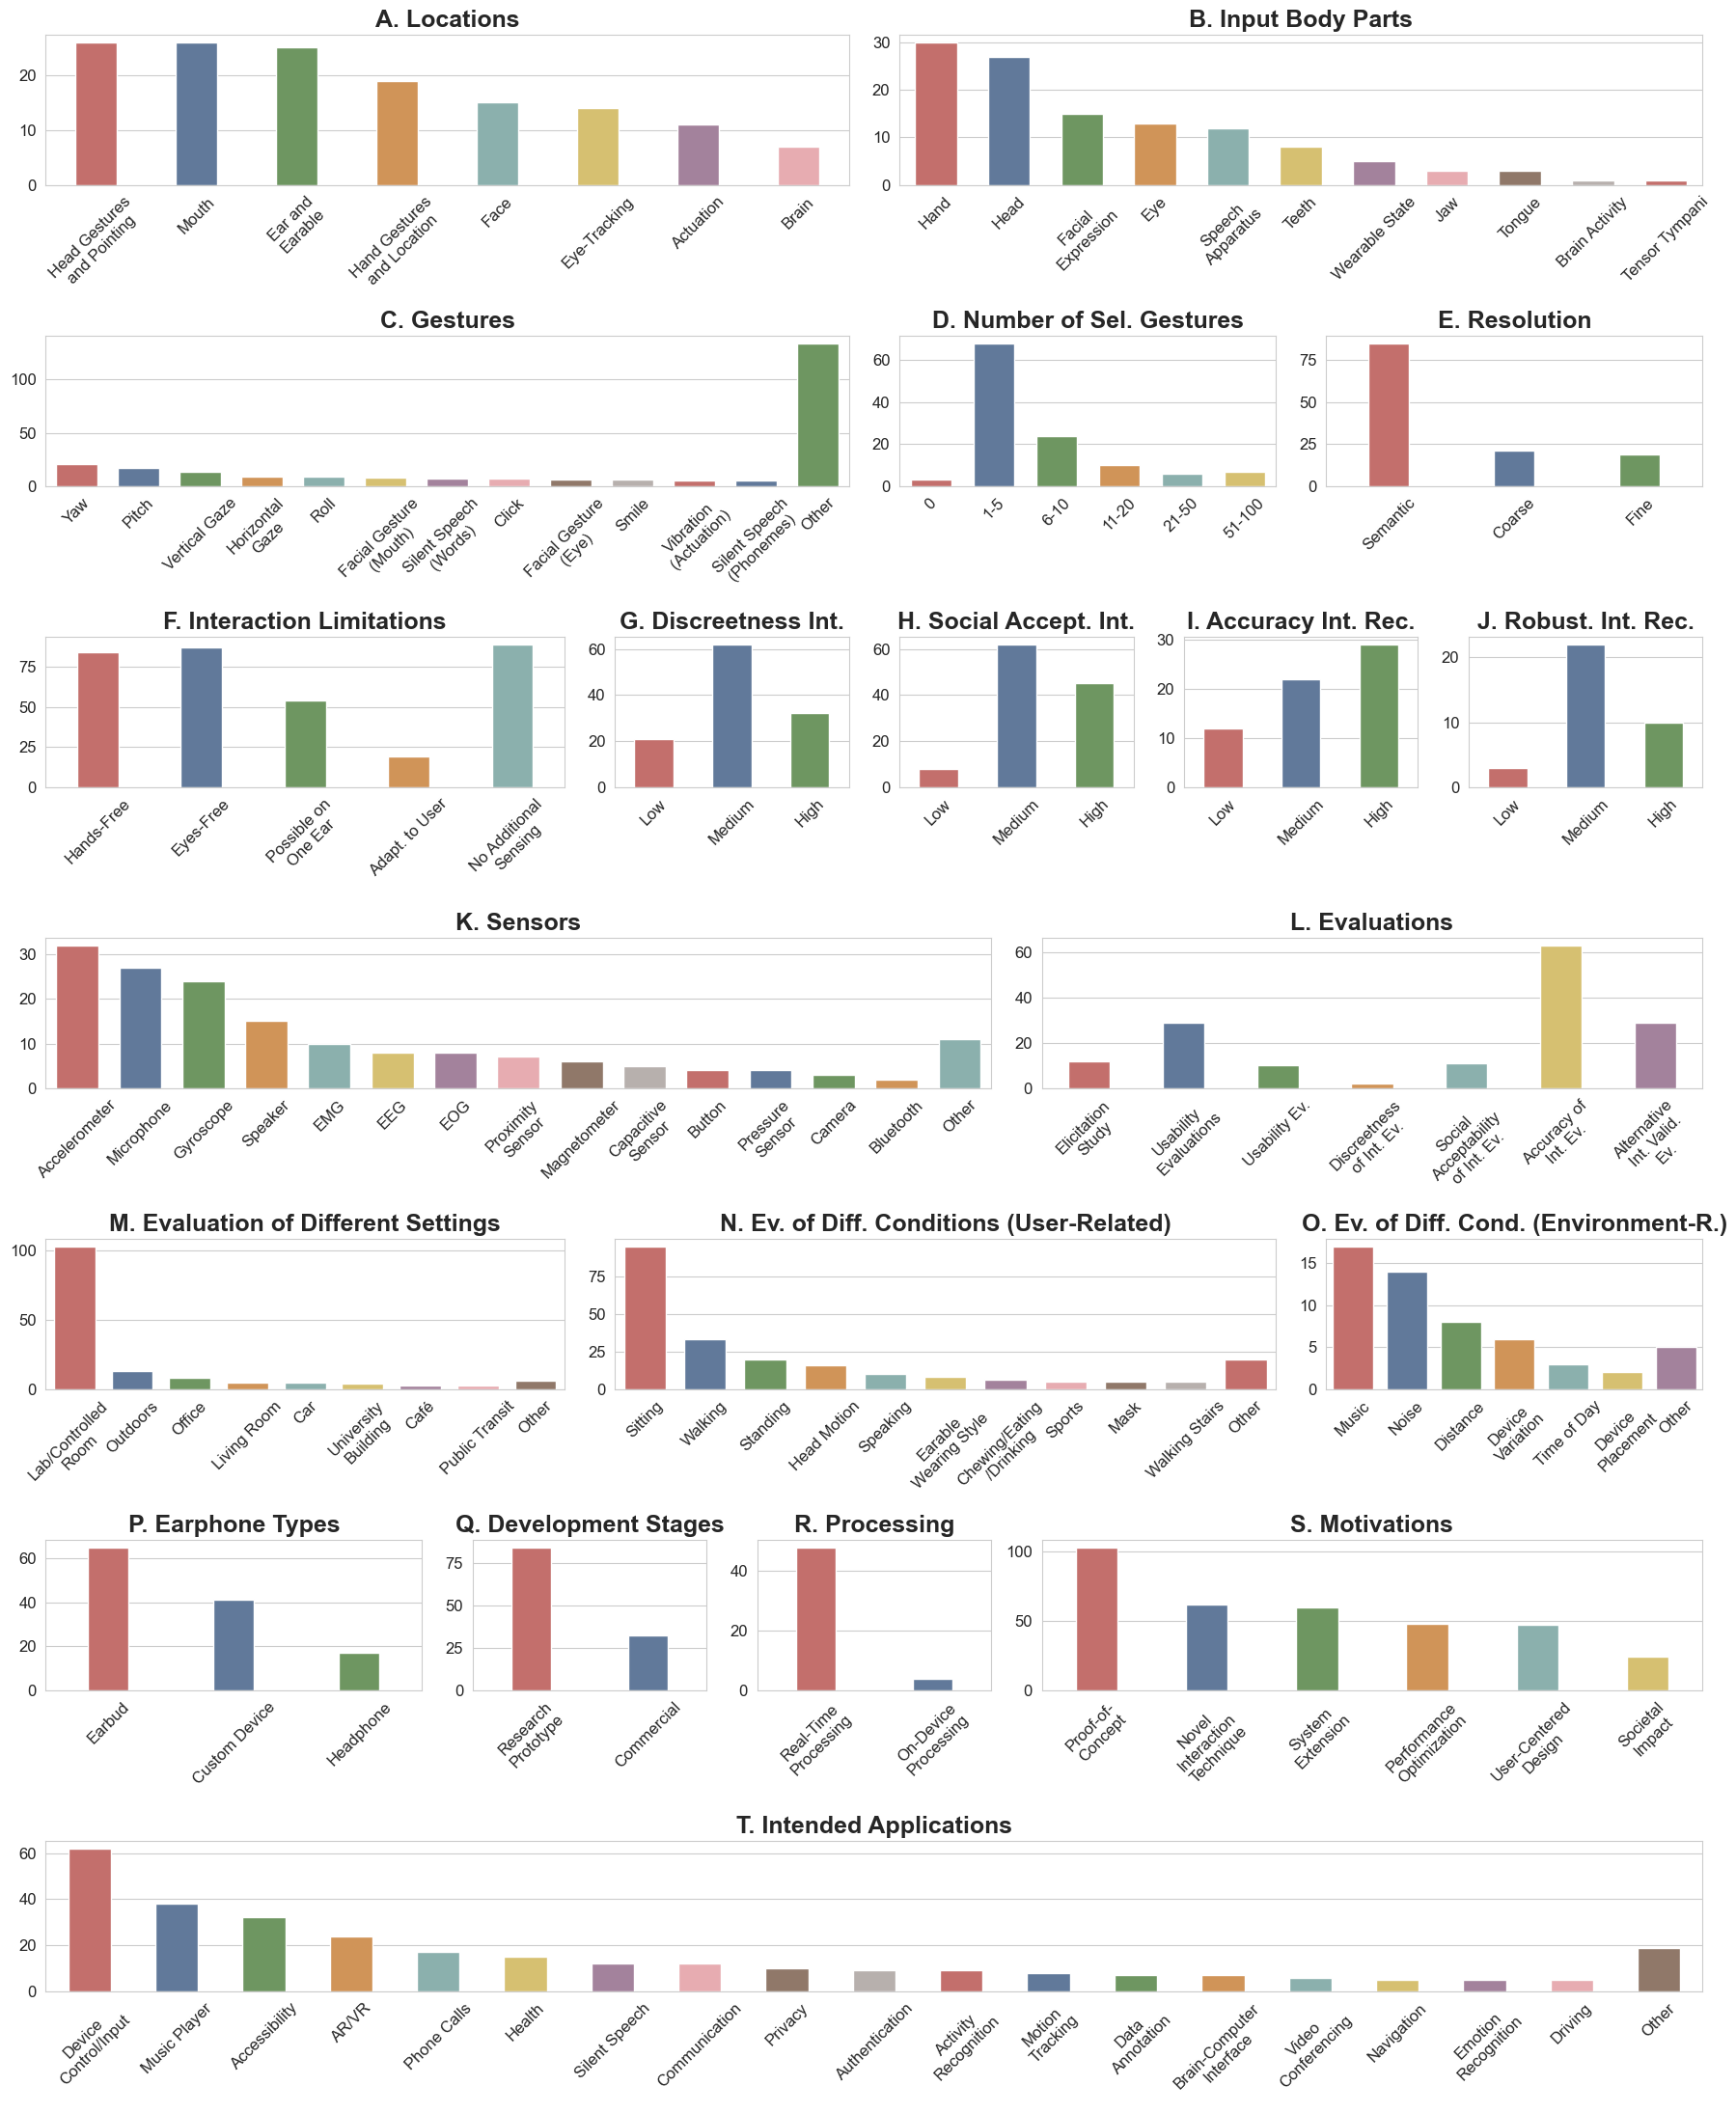

In [5]:
sns.set_style("whitegrid")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Define desired absolute bar width in inches
absolute_bar_width_inches = 0.3  # Adjust this to your preference

# Function to calculate appropriate seaborn width parameter
def calculate_bar_width(ax, num_bars, absolute_width_inches):
    # Get the subplot width in inches
    bbox = ax.get_position()
    fig_width_inches = ax.figure.get_figwidth()
    subplot_width_inches = bbox.width * fig_width_inches
    
    # Calculate the appropriate width parameter
    # (this accounts for seaborn's internal spacing)
    width_param = (absolute_width_inches * num_bars) / subplot_width_inches * 1.2
    
    # Limit the width to avoid bars touching each other
    return min(width_param, 0.8)

# For a minimum count threshold (e.g., 5):
def aggregate_with_threshold(series, min_count=5):
    value_counts = series.dropna().str.split(',').explode().str.strip().value_counts()
    above_threshold = value_counts[value_counts >= min_count].to_dict()
    below_threshold_sum = value_counts[value_counts < min_count].sum()
    
    result = {**above_threshold}
    if below_threshold_sum > 0:
        result['Other'] = below_threshold_sum
    
    return result

# Function to create binned counts
def create_bins(series):
    # Convert to numeric, handling any non-numeric values
    numeric_series = pd.to_numeric(series.dropna(), errors='coerce').dropna()
    
    # Define bins and labels
    bins = [0, 1, 6, 11, 21, 51, 101]
    labels = ['0', '1-5', '6-10', '11-20', '21-50', '51-100']
    
    # Create binned data
    binned = pd.cut(numeric_series, bins=bins, labels=labels, include_lowest=True, right=False)
    
    # Get value counts and reindex to maintain order
    value_counts = binned.value_counts()
    
    # Create ordered dictionary with all bins (even if count is 0)
    from collections import OrderedDict
    result = OrderedDict()
    for label in labels:
        result[label] = value_counts.get(label, 0)
    
    return result

def create_ordered_quality_counts(series):
    # Clean the series and get value counts
    value_counts = series.dropna().str.split(',').explode().str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).value_counts()
    
    # Define the desired order
    ordered_labels = ['Low', 'Medium', 'High']
    
    # Create ordered dictionary with consistent order
    from collections import OrderedDict
    result = OrderedDict()
    for label in ordered_labels:
        result[label] = value_counts.get(label, 0)
    
    return result

# Extract data into dictionaries for labels and values
data_dict = [
    dict(df['Location'].dropna().str.split(',').explode().str.strip().value_counts()),
    dict(df['Input Body Part'].dropna().str.split(',').explode().str.strip().value_counts()),
    aggregate_with_threshold(df['Gesture'], min_count=5),
    create_bins(df['Interaction_PANEL_Number of Selected Gestures']),
    dict(df['Interaction_PANEL_Resolution'].dropna().str.split(',').explode().str.strip().value_counts()),
        {
        'Hands-Free': df['Interaction_PANEL_Hands-Free'].str.strip().str.contains('Yes', na=False).sum(),
        'Eyes-Free': df['Interaction_PANEL_Eyes-Free'].str.strip().str.contains('Yes', na=False).sum(),
        'Possible on One Ear': df['Interaction_PANEL_Possible on One Ear'].str.strip().eq('Yes').sum(),
        'Adapt. to User': df['Interaction_PANEL_Adaptation of the Interaction Detection Algorithm to User'].str.strip().str.contains('Yes', na=False).sum(),
        'No Additional Sensing': df['Sensing_PANEL_No Additional Sensing'].str.strip().str.contains('Yes', na=False).sum(),
    },
    create_ordered_quality_counts(df['Interaction_PANEL_Discreetness of Interaction Techniques']),
    create_ordered_quality_counts(df['Interaction_PANEL_Social Acceptability of Interaction Techniques']),
    create_ordered_quality_counts(df['Interaction_PANEL_Accuracy of Interaction Recognition']),
    create_ordered_quality_counts(df['Interaction_PANEL_Robustness of Interaction Detection']),   
    aggregate_with_threshold(df['Sensing_PANEL_Sensors'], min_count=2),
    {
        'Elicitation Study': df['Study_PANEL_Elicitation Study'].str.strip().str.contains('Yes', na=False).sum(),
        'Usability Evaluations': df['Study_PANEL_Usability Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Cognitive Ease Evaluations': df['Study_PANEL_Cognitive Ease Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Discreetness of Interactions Evaluations': df['Study_PANEL_Discreetness of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Social Acceptability of Interactions Evaluations': df['Study_PANEL_Social Acceptability of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Accuracy of Interactions Evaluations': df['Study_PANEL_Accuracy of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Alternative Interaction Validity Evaluations': df['Study_PANEL_Alternative Interaction Validity Evaluations'].str.strip().str.contains('Yes', na=False).sum()
    },
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Settings'], min_count=3),
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Conditions (User-Related)'], min_count=3),
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Conditions (Environment-Related)'], min_count=2),
    dict(df['Device_PANEL_Earphone Type'].dropna().str.split(',').explode().str.strip().value_counts()),
    dict(df['Device_PANEL_Development Stage'].dropna().str.split(',').explode().str.strip().value_counts()), 
    {
        'Real-Time Processing': df['Device_PANEL_Real-Time Processing'].str.strip().eq('Yes').sum(),
        'On-Device Processing': df['Device_PANEL_On-Device Processing'].str.strip().eq('Yes').sum()
    },
    dict(df['Motivations_PANEL_Motivations'].dropna().str.split(',').explode().str.strip().value_counts()),
    aggregate_with_threshold(df['Applications_PANEL_Intended Applications'], min_count=5),

]

# Create a figure
fig = plt.figure(figsize=(18, 22))  # Adjust figure size as needed

# Use GridSpec to define the layout
gs = GridSpec(7, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1, 1, 1])  # Custom widths and heights

# First row: 2 plots
custom_colors = ['#d1615d', '#5778a4', '#6a9f58', '#e49444', '#85b6b2', '#e7ca60', '#a87c9f', '#f1a2a9', '#967662', '#b8b0ac']

# First row: Top Locations
ax1 = fig.add_subplot(gs[0, :6])  # First plot spans 3 columns
labels, values = zip(*data_dict[0].items())
bar_width = calculate_bar_width(ax1, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax1, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax1.set_title("A. Locations", fontweight='bold')
ax1.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax1.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# First row: Top Body Parts
ax2 = fig.add_subplot(gs[0, 6:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[1].items())
bar_width = calculate_bar_width(ax2, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax2, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax2.set_title("B. Input Body Parts", fontweight='bold')
ax2.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax2.set_xticklabels(wrapped_labels, rotation=45, ha='center')  # Using 'labels' instead of 'wrapped_labels'

# Second: Gesture
ax3 = fig.add_subplot(gs[1, :6])  # Second plot spans 3 columns
labels, values = zip(*data_dict[2].items())
bar_width = calculate_bar_width(ax3, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax3, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax3.set_title("C. Gestures", fontweight='bold')
ax3.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax3.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Second: NumGestures
ax13 = fig.add_subplot(gs[1, 6:9])  # Second plot spans 3 columns
labels, values = zip(*data_dict[3].items())
bar_width = calculate_bar_width(ax13, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax13, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax13.set_title("D. Number of Sel. Gestures", fontweight='bold')
ax13.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax13.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Second: Resolution
ax14 = fig.add_subplot(gs[1, 9:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[4].items())
bar_width = calculate_bar_width(ax14, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax14, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax14.set_title("E. Resolution", fontweight='bold')
ax14.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax14.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Interaction Limitations
ax15 = fig.add_subplot(gs[2, :4])  # Second plot spans 3 columns
labels, values = zip(*data_dict[5].items())
bar_width = calculate_bar_width(ax15, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax15, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax15.set_title("F. Interaction Limitations", fontweight='bold')
ax15.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax15.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Discreetness of Interaction Techniques
ax16 = fig.add_subplot(gs[2, 4:6])  # Second plot spans 3 columns
labels, values = zip(*data_dict[6].items())
bar_width = calculate_bar_width(ax16, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax16, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax16.set_title("G. Discreetness Int.", fontweight='bold')
ax16.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax16.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Social Acceptability of Interaction Techniques
ax17 = fig.add_subplot(gs[2, 6:8])  # Second plot spans 3 columns
labels, values = zip(*data_dict[7].items())
bar_width = calculate_bar_width(ax17, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax17, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax17.set_title("H. Social Accept. Int.", fontweight='bold')
ax17.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax17.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Accuracy of Interaction Recognition
ax18 = fig.add_subplot(gs[2, 8:10])  # Second plot spans 3 columns
labels, values = zip(*data_dict[8].items())
bar_width = calculate_bar_width(ax18, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax18, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax18.set_title("I. Accuracy Int. Rec.", fontweight='bold')
ax18.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax18.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Robustness of Interaction Detection
ax19 = fig.add_subplot(gs[2, 10:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[9].items())
bar_width = calculate_bar_width(ax19, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax19, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax19.set_title("J. Robust. Int. Rec.", fontweight='bold')
ax19.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax19.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fourth row: Sensors
ax20 = fig.add_subplot(gs[3, :7])  # Second plot spans 3 columns
labels, values = zip(*data_dict[10].items())
bar_width = calculate_bar_width(ax20, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax20, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax20.set_title("K. Sensors", fontweight='bold')
ax20.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax20.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fourth row: Evaluations
ax4 = fig.add_subplot(gs[3, 7:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[11].items())
bar_width = calculate_bar_width(ax4, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax4, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax4.set_title("L. Evaluations", fontweight='bold')
ax4.set_xticks(range(len(labels)))
labels = list(labels)  # Convert to list for manipulation
labels[2] = 'Usability Ev.'  # Adjust label for better readability
labels[3] = 'Discreetness of Int. Ev.'  # Adjust label for better readability
labels[4] = 'Social Acceptability of Int. Ev.'  # Adjust label for better readability
labels[5] = 'Accuracy of Int. Ev.'  # Adjust label for better readability
labels[6] = 'Alternative Int. Valid. Ev.'  # Adjust label for better readability
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax4.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Settings
ax7 = fig.add_subplot(gs[4, :4])  # Fifth plot spans 2 columns
labels, values = zip(*data_dict[12].items())
bar_width = calculate_bar_width(ax7, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax7, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax7.set_title("M. Evaluation of Different Settings", fontweight='bold')
ax7.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax7.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Conditions User-Related
ax5 = fig.add_subplot(gs[4, 4:9])  # Third plot spans 2 columns
labels, values = zip(*data_dict[13].items())
bar_width = calculate_bar_width(ax5, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax5, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax5.set_title("N. Ev. of Diff. Conditions (User-Related)", fontweight='bold')
ax5.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax5.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Conditions Environment-Related
ax6 = fig.add_subplot(gs[4, 9:])  # Third plot spans 2 columns
labels, values = zip(*data_dict[14].items())
bar_width = calculate_bar_width(ax6, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax6, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax6.set_title("O. Ev. of Diff. Cond. (Environment-R.)", fontweight='bold')
ax6.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax6.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: Earphone Types
ax8 = fig.add_subplot(gs[5, :3])  # Third plot spans 2 columns
labels, values = zip(*data_dict[15].items())
bar_width = calculate_bar_width(ax8, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax8, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax8.set_title("P. Earphone Types", fontweight='bold')
ax8.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax8.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: Development Stage
ax9 = fig.add_subplot(gs[5, 3:5])  # Third plot spans 2 columns
labels, values = zip(*data_dict[16].items())
bar_width = calculate_bar_width(ax9, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax9, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax9.set_title("Q. Development Stages", fontweight='bold')
ax9.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax9.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: On Device and Real-Time
ax10 = fig.add_subplot(gs[5, 5:7])  # Third plot spans 2 columns
labels, values = zip(*data_dict[17].items())
bar_width = calculate_bar_width(ax10, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax10, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax10.set_title("R. Processing", fontweight='bold')
ax10.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax10.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: Motivations
ax11 = fig.add_subplot(gs[5, 7:])  # Third plot spans 2 columns
labels, values = zip(*data_dict[18].items())
bar_width = calculate_bar_width(ax11, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax11, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax11.set_title("S. Motivations", fontweight='bold')
ax11.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax11.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Seventh row: Applications
ax12 = fig.add_subplot(gs[6, :])  # Third plot spans 2 columns
labels, values = zip(*data_dict[19].items())
bar_width = calculate_bar_width(ax12, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax12, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax12.set_title("T. Intended Applications", fontweight='bold')
ax12.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax12.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/bar_chart_overview.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:131: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax1, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:141: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax2, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:151: UserWarning: 
The palette list has fewer values (10) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax3, hue=labels, palette=custom_colors, legend=False, width=bar_width)


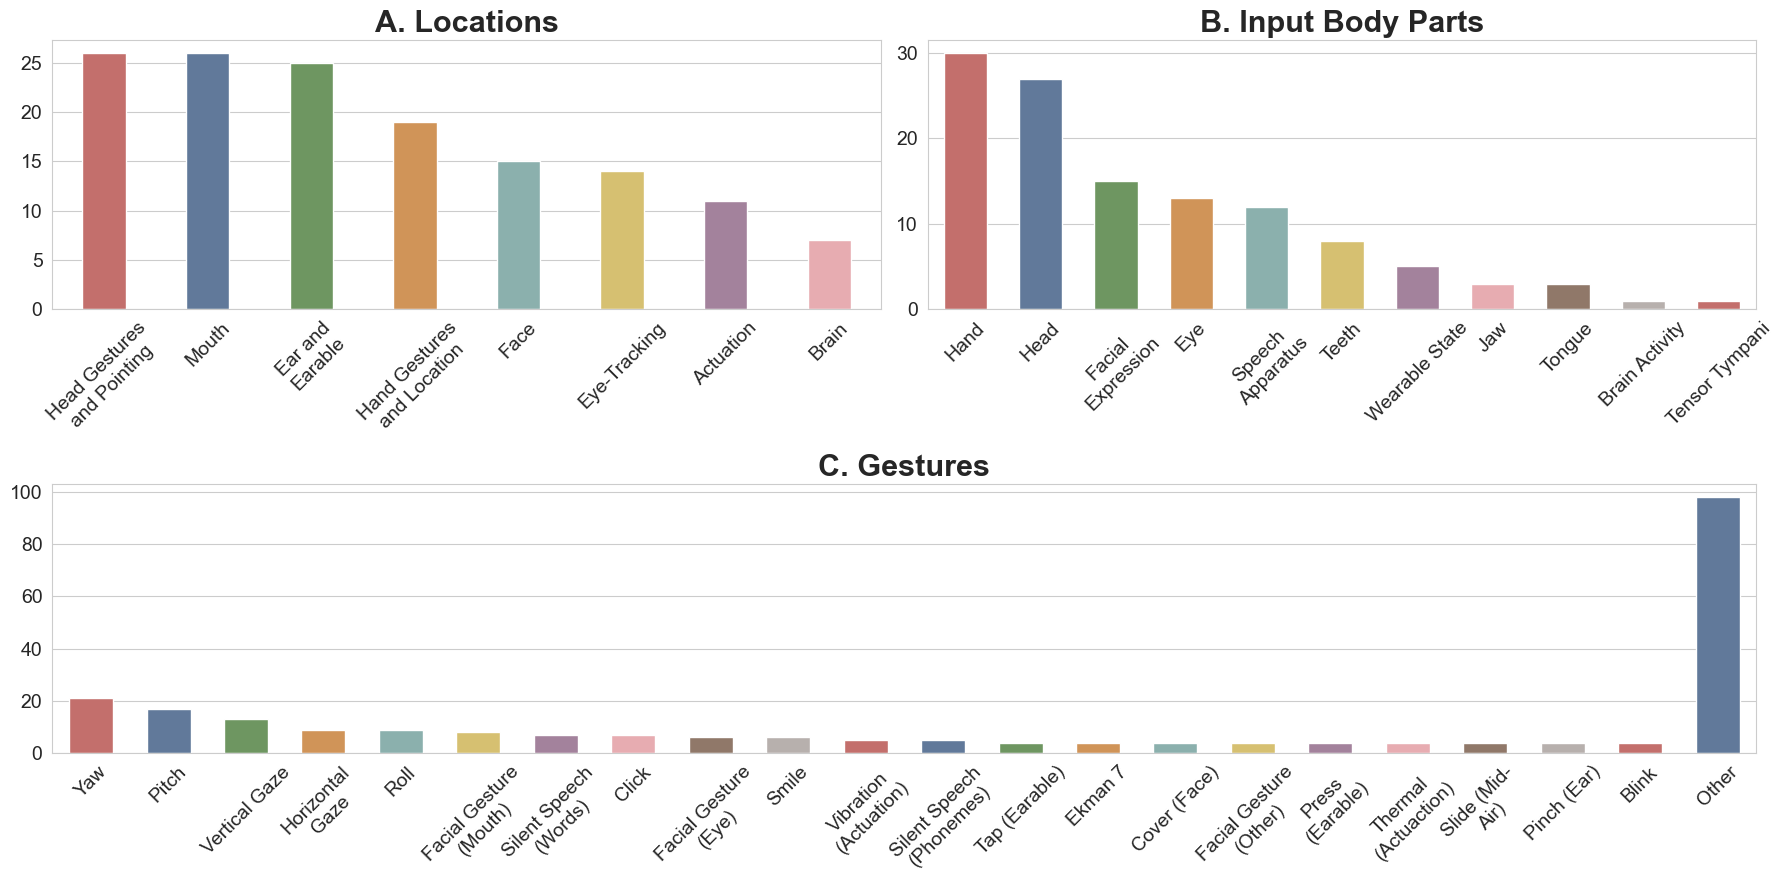

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:172: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax13, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:182: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax14, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:192: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax15, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:202: UserWarning: The palette list has more values (10) than needed (3), which may not be int

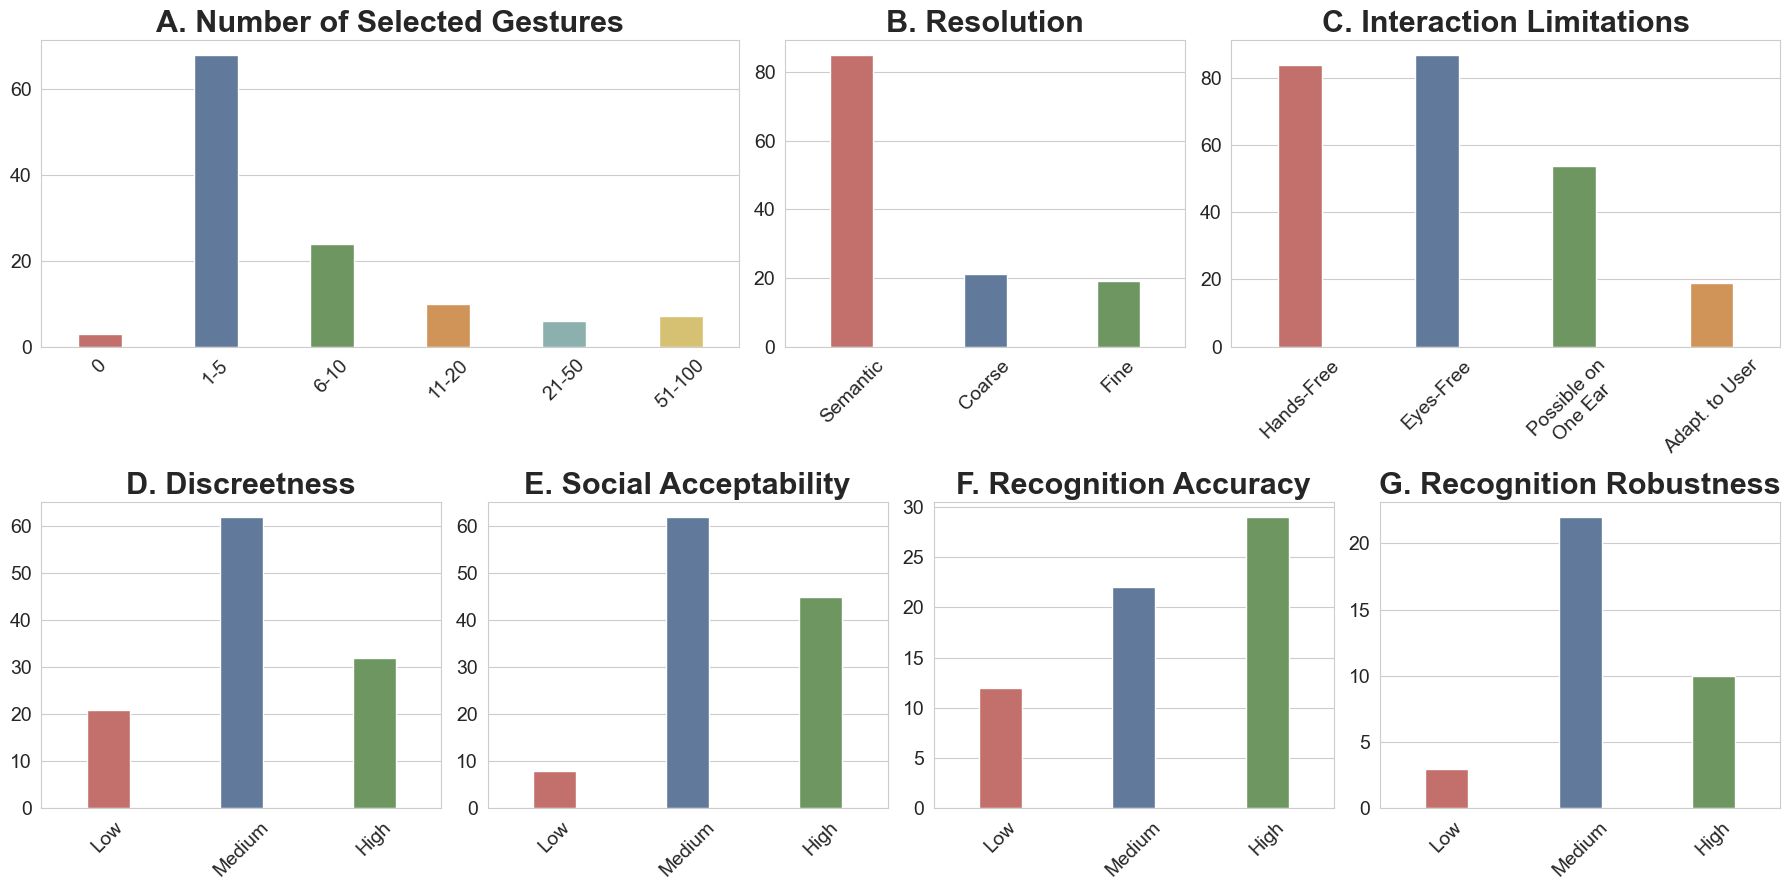

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:253: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax20, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:262: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax21, hue=labels, palette=custom_colors, legend=False, width=bar_width)


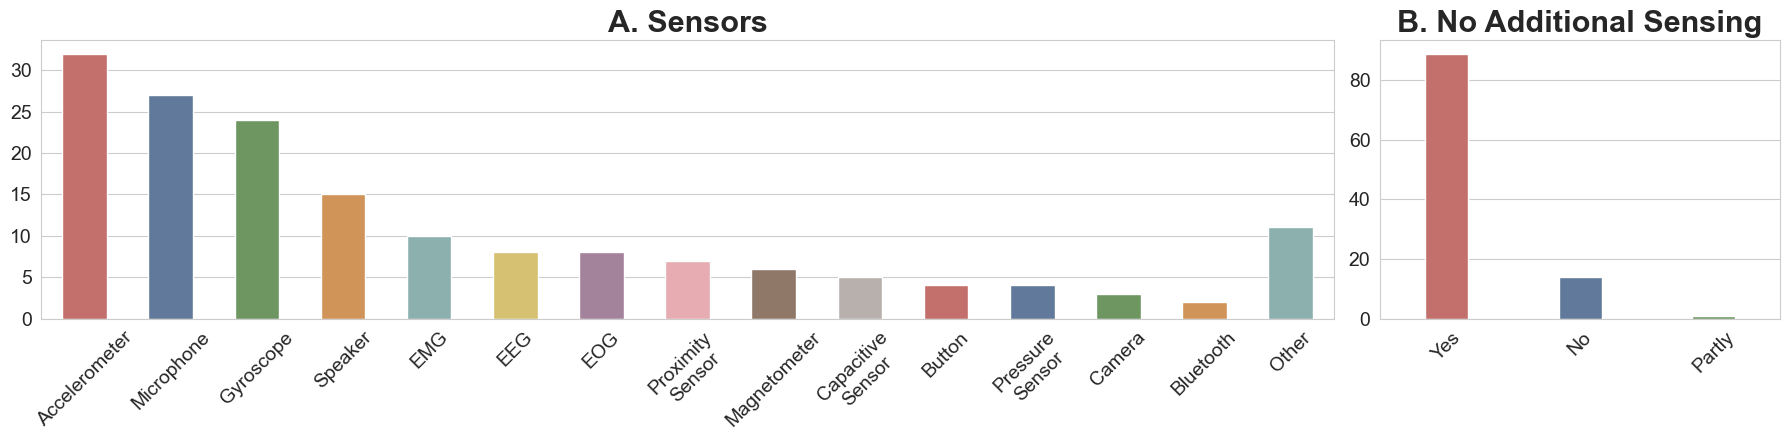

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:283: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax4, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:299: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax7, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:309: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax5, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:319: UserWarning: The palette list has more values (10) than n

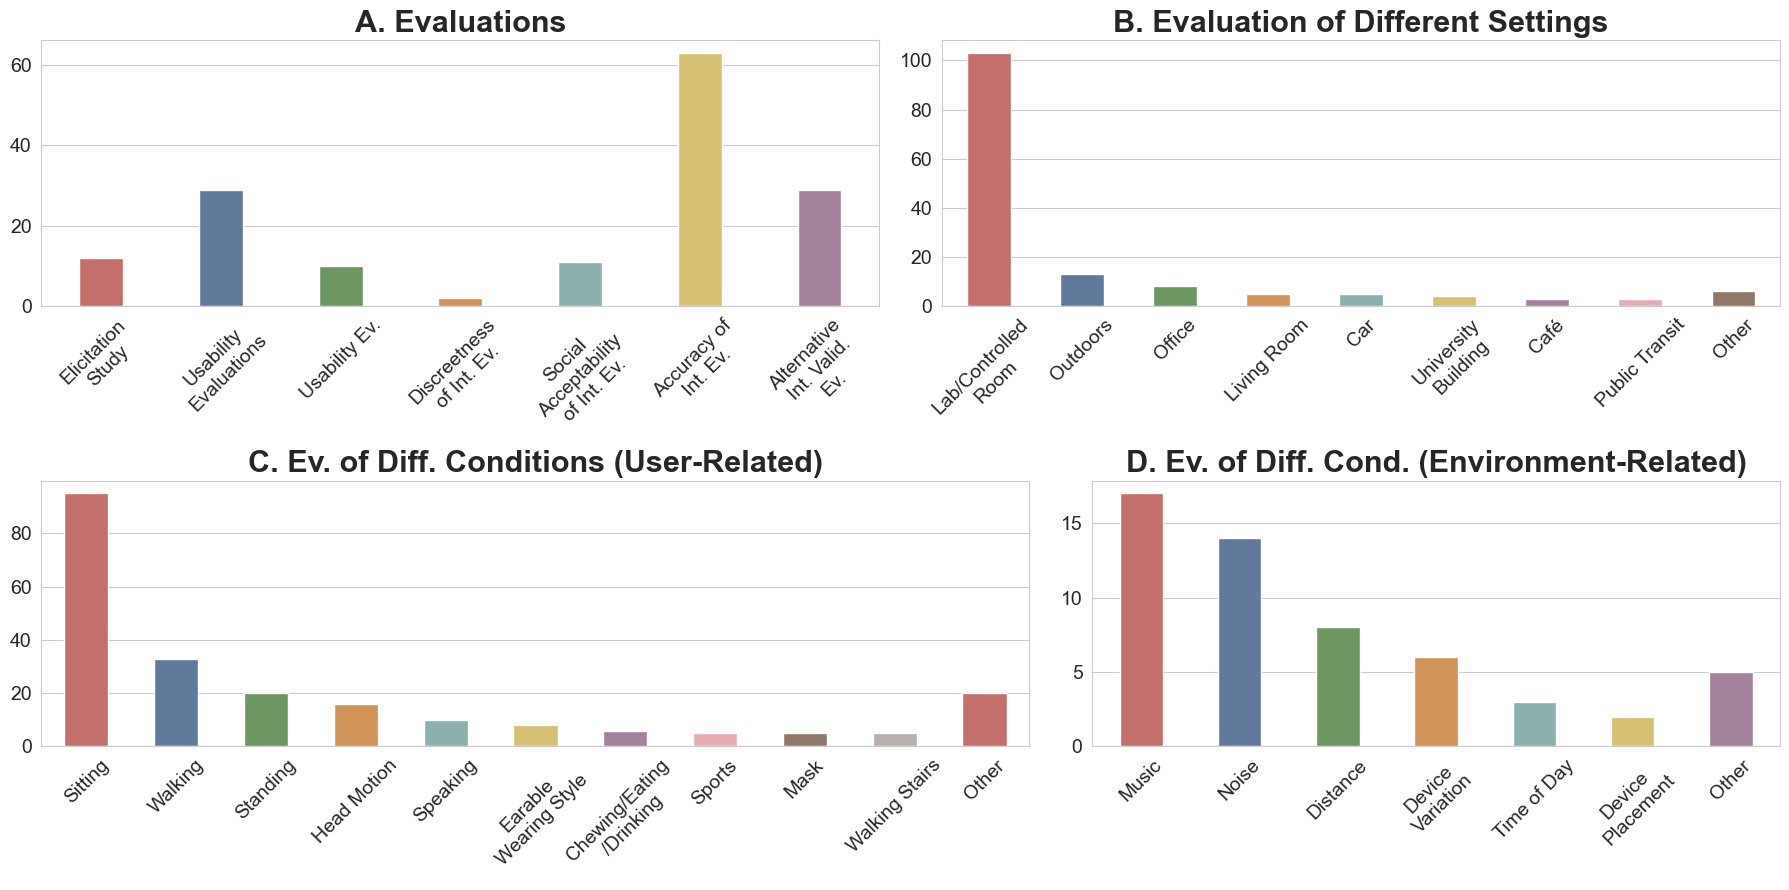

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:340: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax8, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:350: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax9, hue=labels, palette=custom_colors, legend=False, width=bar_width)
C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:360: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax10, hue=labels, palette=custom_colors, legend=False, width=bar_width)


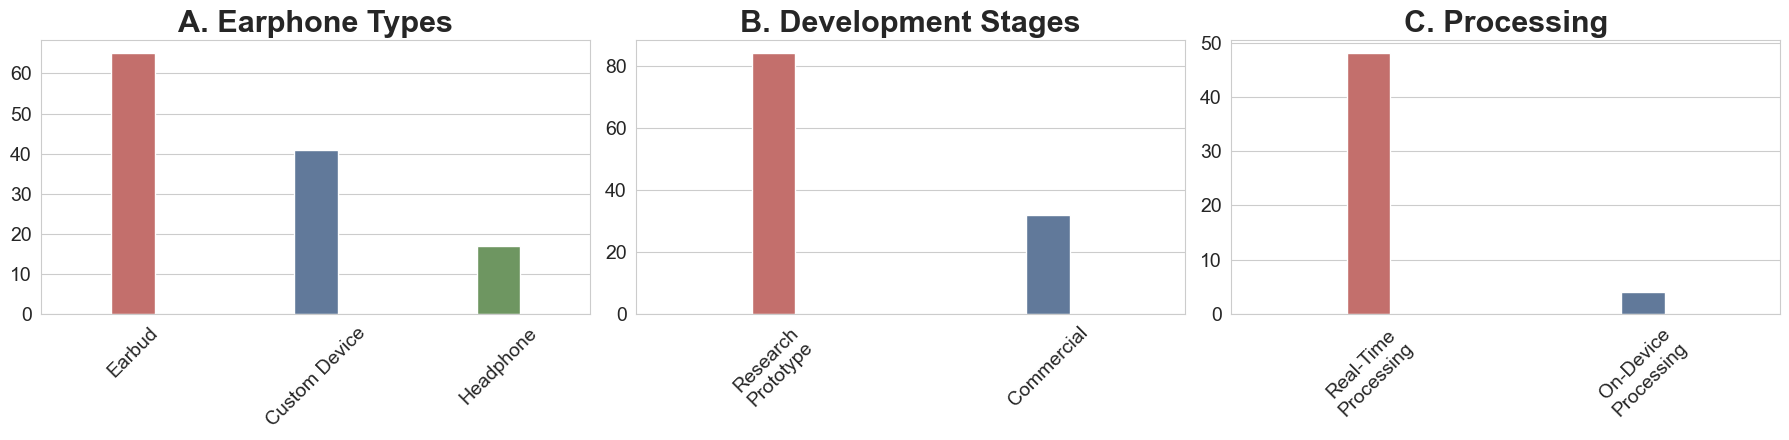

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:380: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x=labels, y=values, ax=ax11, hue=labels, palette=custom_colors, legend=False, width=bar_width)


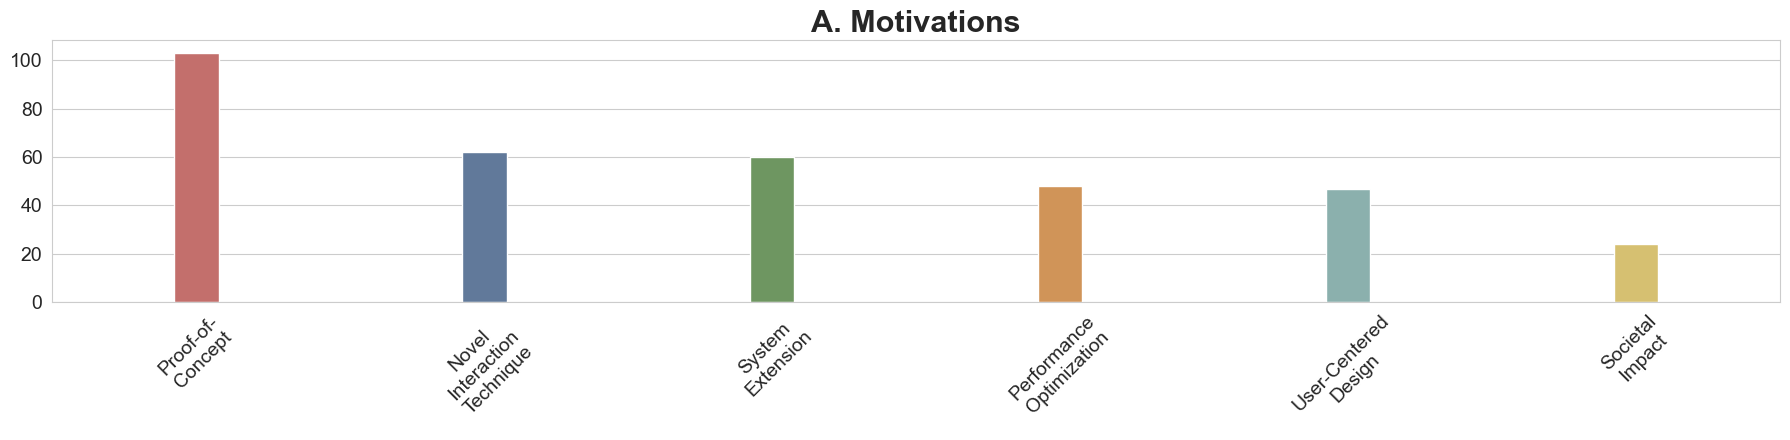

C:\Users\Jonas Hummel\AppData\Local\Temp\ipykernel_14476\727492978.py:401: UserWarning: 
The palette list has fewer values (10) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=values, ax=ax12, hue=labels, palette=custom_colors, legend=False, width=bar_width)


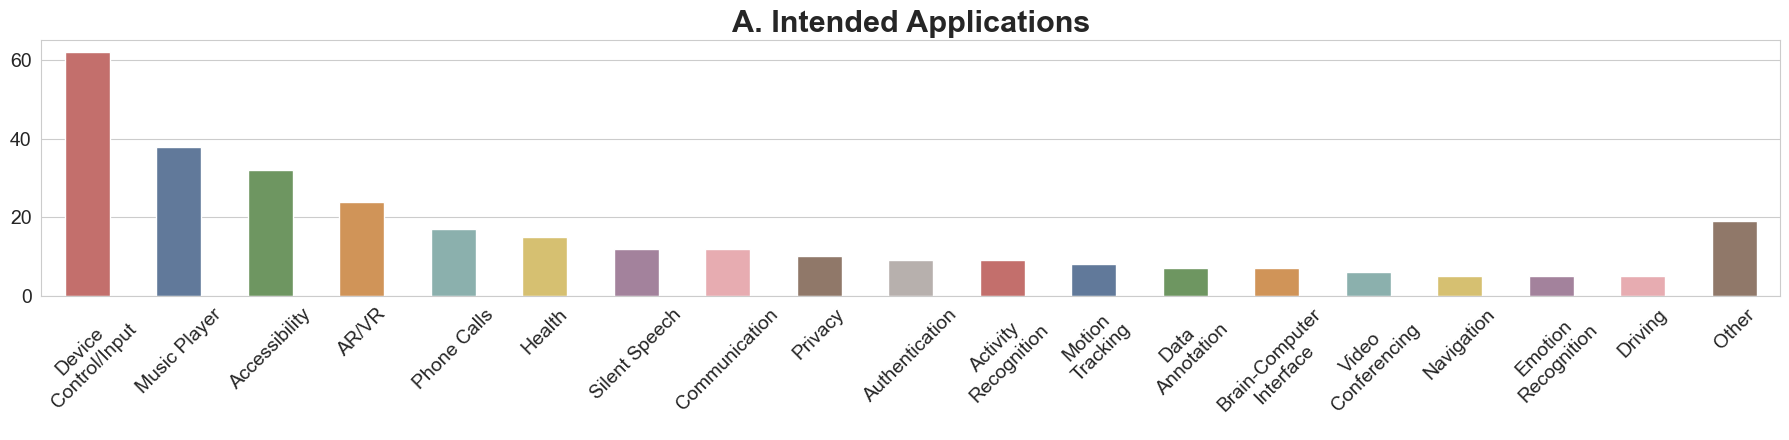

In [6]:
sns.set_style("whitegrid")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Define desired absolute bar width in inches
absolute_bar_width_inches = 0.3  # Adjust this to your preference

# Function to calculate appropriate seaborn width parameter
def calculate_bar_width(ax, num_bars, absolute_width_inches):
    # Get the subplot width in inches
    bbox = ax.get_position()
    fig_width_inches = ax.figure.get_figwidth()
    subplot_width_inches = bbox.width * fig_width_inches
    
    # Calculate the appropriate width parameter
    # (this accounts for seaborn's internal spacing)
    width_param = (absolute_width_inches * num_bars) / subplot_width_inches * 1.2
    
    # Limit the width to avoid bars touching each other
    return min(width_param, 0.8)

# For a minimum count threshold (e.g., 5):
def aggregate_with_threshold(series, min_count=5):
    value_counts = series.dropna().str.split(',').explode().str.strip().value_counts()
    above_threshold = value_counts[value_counts >= min_count].to_dict()
    below_threshold_sum = value_counts[value_counts < min_count].sum()
    
    result = {**above_threshold}
    if below_threshold_sum > 0:
        result['Other'] = below_threshold_sum
    
    return result

# Function to create binned counts
def create_bins(series):
    # Convert to numeric, handling any non-numeric values
    numeric_series = pd.to_numeric(series.dropna(), errors='coerce').dropna()
    
    # Define bins and labels
    bins = [0, 1, 6, 11, 21, 51, 101]
    labels = ['0', '1-5', '6-10', '11-20', '21-50', '51-100']
    
    # Create binned data
    binned = pd.cut(numeric_series, bins=bins, labels=labels, include_lowest=True, right=False)
    
    # Get value counts and reindex to maintain order
    value_counts = binned.value_counts()
    
    # Create ordered dictionary with all bins (even if count is 0)
    from collections import OrderedDict
    result = OrderedDict()
    for label in labels:
        result[label] = value_counts.get(label, 0)
    
    return result

def create_ordered_quality_counts(series):
    # Clean the series and get value counts
    value_counts = series.dropna().str.split(',').explode().str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).value_counts()
    
    # Define the desired order
    ordered_labels = ['Low', 'Medium', 'High']
    
    # Create ordered dictionary with consistent order
    from collections import OrderedDict
    result = OrderedDict()
    for label in ordered_labels:
        result[label] = value_counts.get(label, 0)
    
    return result

# Extract data into dictionaries for labels and values
data_dict = [
    dict(df['Location'].dropna().str.split(',').explode().str.strip().value_counts()),
    dict(df['Input Body Part'].dropna().str.split(',').explode().str.strip().value_counts()),
    aggregate_with_threshold(df['Gesture'], min_count=4),
    create_bins(df['Interaction_PANEL_Number of Selected Gestures']),
    dict(df['Interaction_PANEL_Resolution'].dropna().str.split(',').explode().str.strip().value_counts()),
        {
        'Hands-Free': df['Interaction_PANEL_Hands-Free'].str.strip().str.contains('Yes', na=False).sum(),
        'Eyes-Free': df['Interaction_PANEL_Eyes-Free'].str.strip().str.contains('Yes', na=False).sum(),
        'Possible on One Ear': df['Interaction_PANEL_Possible on One Ear'].str.strip().eq('Yes').sum(),
        'Adapt. to User': df['Interaction_PANEL_Adaptation of the Interaction Detection Algorithm to User'].str.strip().str.contains('Yes', na=False).sum(),
    },
    create_ordered_quality_counts(df['Interaction_PANEL_Discreetness of Interaction Techniques']),
    create_ordered_quality_counts(df['Interaction_PANEL_Social Acceptability of Interaction Techniques']),
    create_ordered_quality_counts(df['Interaction_PANEL_Accuracy of Interaction Recognition']),
    create_ordered_quality_counts(df['Interaction_PANEL_Robustness of Interaction Detection']),   
    aggregate_with_threshold(df['Sensing_PANEL_Sensors'], min_count=2),
    dict(df['Sensing_PANEL_No Additional Sensing'].dropna().str.split(',').explode().str.strip().value_counts()),
    {
        'Elicitation Study': df['Study_PANEL_Elicitation Study'].str.strip().str.contains('Yes', na=False).sum(),
        'Usability Evaluations': df['Study_PANEL_Usability Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Cognitive Ease Evaluations': df['Study_PANEL_Cognitive Ease Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Discreetness of Interactions Evaluations': df['Study_PANEL_Discreetness of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Social Acceptability of Interactions Evaluations': df['Study_PANEL_Social Acceptability of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Accuracy of Interactions Evaluations': df['Study_PANEL_Accuracy of Interactions Evaluations'].str.strip().str.contains('Yes', na=False).sum(),
        'Alternative Interaction Validity Evaluations': df['Study_PANEL_Alternative Interaction Validity Evaluations'].str.strip().str.contains('Yes', na=False).sum()
    },
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Settings'], min_count=3),
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Conditions (User-Related)'], min_count=3),
    aggregate_with_threshold(df['Study_PANEL_Evaluation of Different Conditions (Environment-Related)'], min_count=2),
    dict(df['Device_PANEL_Earphone Type'].dropna().str.split(',').explode().str.strip().value_counts()),
    dict(df['Device_PANEL_Development Stage'].dropna().str.split(',').explode().str.strip().value_counts()), 
    {
        'Real-Time Processing': df['Device_PANEL_Real-Time Processing'].str.strip().eq('Yes').sum(),
        'On-Device Processing': df['Device_PANEL_On-Device Processing'].str.strip().eq('Yes').sum()
    },
    dict(df['Motivations_PANEL_Motivations'].dropna().str.split(',').explode().str.strip().value_counts()),
    aggregate_with_threshold(df['Applications_PANEL_Intended Applications'], min_count=5),

]

# First row: 2 plots
custom_colors = ['#d1615d', '#5778a4', '#6a9f58', '#e49444', '#85b6b2', '#e7ca60', '#a87c9f', '#f1a2a9', '#967662', '#b8b0ac']

# Create a figure
fig = plt.figure(figsize=(18, 9))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(2, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])  # Custom widths and heights

# First row: Top Locations
ax1 = fig.add_subplot(gs[0, :6])  # First plot spans 3 columns
labels, values = zip(*data_dict[0].items())
bar_width = calculate_bar_width(ax1, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax1, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax1.set_title("A. Locations", fontweight='bold')
ax1.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax1.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# First row: Top Body Parts
ax2 = fig.add_subplot(gs[0, 6:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[1].items())
bar_width = calculate_bar_width(ax2, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax2, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax2.set_title("B. Input Body Parts", fontweight='bold')
ax2.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax2.set_xticklabels(wrapped_labels, rotation=45, ha='center')  # Using 'labels' instead of 'wrapped_labels'

# Second: Gesture
ax3 = fig.add_subplot(gs[1, :])  # Second plot spans 3 columns
labels, values = zip(*data_dict[2].items())
bar_width = calculate_bar_width(ax3, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax3, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax3.set_title("C. Gestures", fontweight='bold')
ax3.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax3.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q1.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


# Create a figure
fig = plt.figure(figsize=(18, 9))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(2, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])  # Custom widths and heights

# Second: NumGestures
ax13 = fig.add_subplot(gs[0, :5])  # Second plot spans 3 columns
labels, values = zip(*data_dict[3].items())
bar_width = calculate_bar_width(ax13, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax13, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax13.set_title("A. Number of Selected Gestures", fontweight='bold')
ax13.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax13.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Second: Resolution
ax14 = fig.add_subplot(gs[0, 5:8])  # Second plot spans 3 columns
labels, values = zip(*data_dict[4].items())
bar_width = calculate_bar_width(ax14, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax14, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax14.set_title("B. Resolution", fontweight='bold')
ax14.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax14.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Interaction Limitations
ax15 = fig.add_subplot(gs[0, 8:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[5].items())
bar_width = calculate_bar_width(ax15, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax15, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax15.set_title("C. Interaction Limitations", fontweight='bold')
ax15.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax15.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Discreetness of Interaction Techniques
ax16 = fig.add_subplot(gs[1, :3])  # Second plot spans 3 columns
labels, values = zip(*data_dict[6].items())
bar_width = calculate_bar_width(ax16, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax16, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax16.set_title("D. Discreetness", fontweight='bold')
ax16.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax16.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Social Acceptability of Interaction Techniques
ax17 = fig.add_subplot(gs[1, 3:6])  # Second plot spans 3 columns
labels, values = zip(*data_dict[7].items())
bar_width = calculate_bar_width(ax17, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax17, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax17.set_title("E. Social Acceptability", fontweight='bold')
ax17.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax17.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Accuracy of Interaction Recognition
ax18 = fig.add_subplot(gs[1, 6:9])  # Second plot spans 3 columns
labels, values = zip(*data_dict[8].items())
bar_width = calculate_bar_width(ax18, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax18, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax18.set_title("F. Recognition Accuracy", fontweight='bold')
ax18.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax18.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Third row: Robustness of Interaction Detection
ax19 = fig.add_subplot(gs[1, 9:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[9].items())
bar_width = calculate_bar_width(ax19, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax19, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax19.set_title("G. Recognition Robustness", fontweight='bold')
ax19.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax19.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q2.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


# Create a figure
fig = plt.figure(figsize=(18, 4.5))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(1, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1])  # Custom widths and heights

# Fourth row: Sensors
ax20 = fig.add_subplot(gs[0, :9])  # Second plot spans 3 columns
labels, values = zip(*data_dict[10].items())
bar_width = calculate_bar_width(ax20, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax20, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax20.set_title("A. Sensors", fontweight='bold')
ax20.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax20.set_xticklabels(wrapped_labels, rotation=45, ha='center')

ax21 = fig.add_subplot(gs[0, 9:])  # Second plot spans 3 columns
labels, values = zip(*data_dict[11].items())
bar_width = calculate_bar_width(ax21, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax21, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax21.set_title("B. No Additional Sensing", fontweight='bold')
ax21.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax21.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q3.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


# Create a figure
fig = plt.figure(figsize=(18, 9))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(2, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, 1])  # Custom widths and heights

# Fourth row: Evaluations
ax4 = fig.add_subplot(gs[0, :6])  # Second plot spans 3 columns
labels, values = zip(*data_dict[12].items())
bar_width = calculate_bar_width(ax4, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax4, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax4.set_title("A. Evaluations", fontweight='bold')
ax4.set_xticks(range(len(labels)))
labels = list(labels)  # Convert to list for manipulation
labels[2] = 'Usability Ev.'  # Adjust label for better readability
labels[3] = 'Discreetness of Int. Ev.'  # Adjust label for better readability
labels[4] = 'Social Acceptability of Int. Ev.'  # Adjust label for better readability
labels[5] = 'Accuracy of Int. Ev.'  # Adjust label for better readability
labels[6] = 'Alternative Int. Valid. Ev.'  # Adjust label for better readability
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax4.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Settings
ax7 = fig.add_subplot(gs[0, 6:])  # Fifth plot spans 2 columns
labels, values = zip(*data_dict[13].items())
bar_width = calculate_bar_width(ax7, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax7, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax7.set_title("B. Evaluation of Different Settings", fontweight='bold')
ax7.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax7.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Conditions User-Related
ax5 = fig.add_subplot(gs[1, :7])  # Third plot spans 2 columns
labels, values = zip(*data_dict[14].items())
bar_width = calculate_bar_width(ax5, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax5, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax5.set_title("C. Ev. of Diff. Conditions (User-Related)", fontweight='bold')
ax5.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax5.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Fifth row: Conditions Environment-Related
ax6 = fig.add_subplot(gs[1, 7:])  # Third plot spans 2 columns
labels, values = zip(*data_dict[15].items())
bar_width = calculate_bar_width(ax6, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax6, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax6.set_title("D. Ev. of Diff. Cond. (Environment-Related)", fontweight='bold')
ax6.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax6.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q4.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


# Create a figure
fig = plt.figure(figsize=(18, 4.5))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(1, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1])  # Custom widths and heights

# Sixth row: Earphone Types
ax8 = fig.add_subplot(gs[0, :4])  # Third plot spans 2 columns
labels, values = zip(*data_dict[16].items())
bar_width = calculate_bar_width(ax8, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax8, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax8.set_title("A. Earphone Types", fontweight='bold')
ax8.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax8.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: Development Stage
ax9 = fig.add_subplot(gs[0, 4:8])  # Third plot spans 2 columns
labels, values = zip(*data_dict[17].items())
bar_width = calculate_bar_width(ax9, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax9, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax9.set_title("B. Development Stages", fontweight='bold')
ax9.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax9.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Sixth row: On Device and Real-Time
ax10 = fig.add_subplot(gs[0, 8:])  # Third plot spans 2 columns
labels, values = zip(*data_dict[18].items())
bar_width = calculate_bar_width(ax10, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax10, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax10.set_title("C. Processing", fontweight='bold')
ax10.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax10.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q5.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

# Create a figure
fig = plt.figure(figsize=(18, 4.5))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(1, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1])  # Custom widths and heights

# Sixth row: Motivations
ax11 = fig.add_subplot(gs[0, :])  # Third plot spans 2 columns
labels, values = zip(*data_dict[19].items())
bar_width = calculate_bar_width(ax11, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax11, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax11.set_title("A. Motivations", fontweight='bold')
ax11.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax11.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q6.png", format='png', dpi=300, bbox_inches='tight')
plt.show()


# Create a figure
fig = plt.figure(figsize=(18, 4.5))  # Adjust figure size as needed
# Use GridSpec to define the layout
gs = GridSpec(1, 12, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1])  # Custom widths and heights

# Seventh row: Applications
ax12 = fig.add_subplot(gs[0, :])  # Third plot spans 2 columns
labels, values = zip(*data_dict[20].items())
bar_width = calculate_bar_width(ax12, len(labels), absolute_bar_width_inches)
sns.barplot(x=labels, y=values, ax=ax12, hue=labels, palette=custom_colors, legend=False, width=bar_width)
ax12.set_title("A. Intended Applications", fontweight='bold')
ax12.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]  # Adjust width as needed
ax12.set_xticklabels(wrapped_labels, rotation=45, ha='center')

# Adjust layout
plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/summary_q7.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# At the top of your script, define the desired bar width in inches
absolute_bar_width_inches = 0.15  # Adjust this value to get your desired width

# Define a function to create consistent width bar plots
def create_fixed_width_barplot(ax, labels, values, palette, bar_width_inches):
    # Get the figure width in inches
    fig_width_inches = ax.figure.get_figwidth()
    
    # Get the width of this specific subplot in figure coordinates
    bbox = ax.get_position()
    subplot_width_inches = bbox.width * fig_width_inches
    
    # Calculate bar width in data coordinates
    # The 0.8 factor accounts for some padding between groups of bars
    bar_width_data = bar_width_inches / subplot_width_inches * len(labels) * 0.8
    
    # Create bar plot manually with fixed width
    bars = ax.bar(range(len(labels)), values, width=bar_width_data, color=[palette[i % len(palette)] for i in range(len(labels))])
    
    # Return bars for further customization if needed
    return bars

# Then replace all your seaborn barplot calls with this function:

# First row: Top Locations
labels, values = zip(*data_dict[0].items())
bars = create_fixed_width_barplot(ax1, labels, values, custom_colors, absolute_bar_width_inches)
ax1.set_title("A. Locations", fontweight='bold')
ax1.set_xticks(range(len(labels)))
wrapped_labels = [textwrap.fill(label, width=14) for label in labels]
ax1.set_xticklabels(wrapped_labels, rotation=45, ha='center')

plt.show()

In [8]:
elicitation = [17, 37, 38, 53, 57, 83, 91, 92, 95, 106, 109, 112]
usability = [2, 14, 15, 16, 19, 26, 27, 29, 37, 40, 44, 51, 53, 57, 65, 71, 74, 78, 81, 84, 86, 90, 94, 97, 98, 111, 113, 115, 117]
cognitive_ease = [14, 26, 45, 51, 57, 71, 74, 91, 112, 117]
discreetness = [38, 51]
social_accept = [14, 37, 38, 51, 53, 57, 83, 91, 112, 113, 117]
accuracy = [3, 13, 11, 18, 20, 21, 22, 24, 25, 28, 30, 31, 32, 33, 36, 39, 40, 41, 42, 46, 50, 51, 54, 56, 57, 58, 59,
    61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 73, 75, 76, 78, 79, 82, 84, 88, 89, 90, 91, 95, 98, 99, 100, 101,
    105, 106, 107, 108, 110, 111, 112, 115, 117, 118]
alternative = [6, 8, 10, 16, 26, 34, 35, 43, 52, 54, 55, 58, 60, 74, 77, 80, 81, 82, 85, 86, 90, 97, 101, 102, 103, 108, 113, 114, 116]

In [9]:
def analyze_list_overlaps(lists_dict):
    """
    Analyzes overlaps between lists of paper IDs.
    
    Parameters:
    lists_dict (dict): Dictionary where keys are list names and values are lists of paper IDs
    
    Returns:
    tuple: (overlap_counts, papers_in_lists, overlap_matrix)
        - overlap_counts: Dictionary showing how many papers appear in 1, 2, 3, etc. lists
        - papers_in_lists: Dictionary showing which lists each paper ID belongs to
        - overlap_matrix: DataFrame showing pairwise overlaps between lists
    """
    import pandas as pd
    from collections import defaultdict
    
    # Track which lists each paper appears in
    papers_in_lists = defaultdict(list)
    
    # Get all unique paper IDs
    all_papers = set()
    for name, paper_list in lists_dict.items():
        for paper in paper_list:
            all_papers.add(paper)
            papers_in_lists[paper].append(name)
    
    # Count how many papers appear in 1, 2, 3, etc. lists
    overlap_counts = defaultdict(int)
    for paper, lists in papers_in_lists.items():
        overlap_counts[len(lists)] += 1
    
    # Create overlap matrix
    list_names = list(lists_dict.keys())
    overlap_matrix = pd.DataFrame(0, index=list_names, columns=list_names)
    
    for i, list1 in enumerate(list_names):
        for list2 in list_names:
            # Count overlap between the two lists
            overlap = len(set(lists_dict[list1]) & set(lists_dict[list2]))
            overlap_matrix.loc[list1, list2] = overlap
    
    return overlap_counts, papers_in_lists, overlap_matrix

# Example usage with your lists
lists_dict = {
    'elicitation': elicitation,
    'usability': usability,
    'cognitive_ease': cognitive_ease,
    'discreetness': discreetness,
    'social_accept': social_accept,
    'accuracy': accuracy,
    'alternative': alternative
}

overlap_counts, papers_in_lists, overlap_matrix = analyze_list_overlaps(lists_dict)

# Print results
print("Paper appearance frequency:")
for count, num_papers in sorted(overlap_counts.items()):
    print(f"{num_papers} papers appear in exactly {count} lists")
    
# Print papers by count of list appearances
print("\nDetailed breakdown of papers by appearance count:")
appearance_count_to_papers = {}
for paper_id, lists_containing_paper in papers_in_lists.items():
    count = len(lists_containing_paper)
    if count not in appearance_count_to_papers:
        appearance_count_to_papers[count] = []
    appearance_count_to_papers[count].append(paper_id)

for count, papers in sorted(appearance_count_to_papers.items()):
    if count > 1:  # Only showing papers that appear in 2+ lists
        print(f"\nPapers appearing in {count} lists ({len(papers)} papers):")
        papers_sorted = sorted(papers)
        print(f"IDs: {papers_sorted}")
        
        # Optionally show which lists each paper appears in
        for paper in papers_sorted:
            print(f"  Paper {paper} appears in: {', '.join(papers_in_lists[paper])}")

Paper appearance frequency:
69 papers appear in exactly 1 lists
19 papers appear in exactly 2 lists
9 papers appear in exactly 3 lists
3 papers appear in exactly 4 lists
2 papers appear in exactly 5 lists

Detailed breakdown of papers by appearance count:

Papers appearing in 2 lists (19 papers):
IDs: [16, 40, 54, 58, 65, 78, 81, 82, 83, 84, 86, 95, 97, 98, 101, 106, 108, 111, 115]
  Paper 16 appears in: usability, alternative
  Paper 40 appears in: usability, accuracy
  Paper 54 appears in: accuracy, alternative
  Paper 58 appears in: accuracy, alternative
  Paper 65 appears in: usability, accuracy
  Paper 78 appears in: usability, accuracy
  Paper 81 appears in: usability, alternative
  Paper 82 appears in: accuracy, alternative
  Paper 83 appears in: elicitation, social_accept
  Paper 84 appears in: usability, accuracy
  Paper 86 appears in: usability, alternative
  Paper 95 appears in: elicitation, accuracy
  Paper 97 appears in: usability, alternative
  Paper 98 appears in: usabil

In [10]:
Counter(df['Year'].to_list())

Counter({2024: 19,
         2021: 16,
         2022: 13,
         2023: 12,
         2019: 10,
         2018: 8,
         2020: 7,
         2017: 6,
         2015: 5,
         2016: 4,
         2005: 2,
         2010: 2,
         2011: 2,
         2012: 2,
         2013: 2,
         2014: 2,
         1987: 1,
         2003: 1,
         2004: 1,
         2006: 1,
         2008: 1,
         2009: 1})

In [11]:
# get count of papers per year
year_counter = Counter(df['Year'].to_list())
papers_per_year = dict(year_counter.items())

# only take into account the sensors with at least 5 papers
target_sensors = ['Accelerometer', 'EEG', 'EMG', 'EOG', 'Gyroscope', 'Magnetometer', 'Microphone', 'Proximity Sensor', 'Speaker']

sensor_counts_by_year = defaultdict(lambda: defaultdict(int))

# Process each row
for index, row in df.iterrows():
    year = row['Year']
    sensors_str = row['Sensing_PANEL_Sensors']
    
    # Skip if sensors field is NaN
    if pd.isna(sensors_str):
        continue
    
    # Split by comma and clean up whitespace
    sensors_in_row = [sensor.strip() for sensor in str(sensors_str).split(',')]
    
    # Count each target sensor
    for sensor in sensors_in_row:
        if sensor in target_sensors:
            sensor_counts_by_year[year][sensor] += 1
        else:
            # Add to "Other" category
            sensor_counts_by_year[year]['Other'] += 1

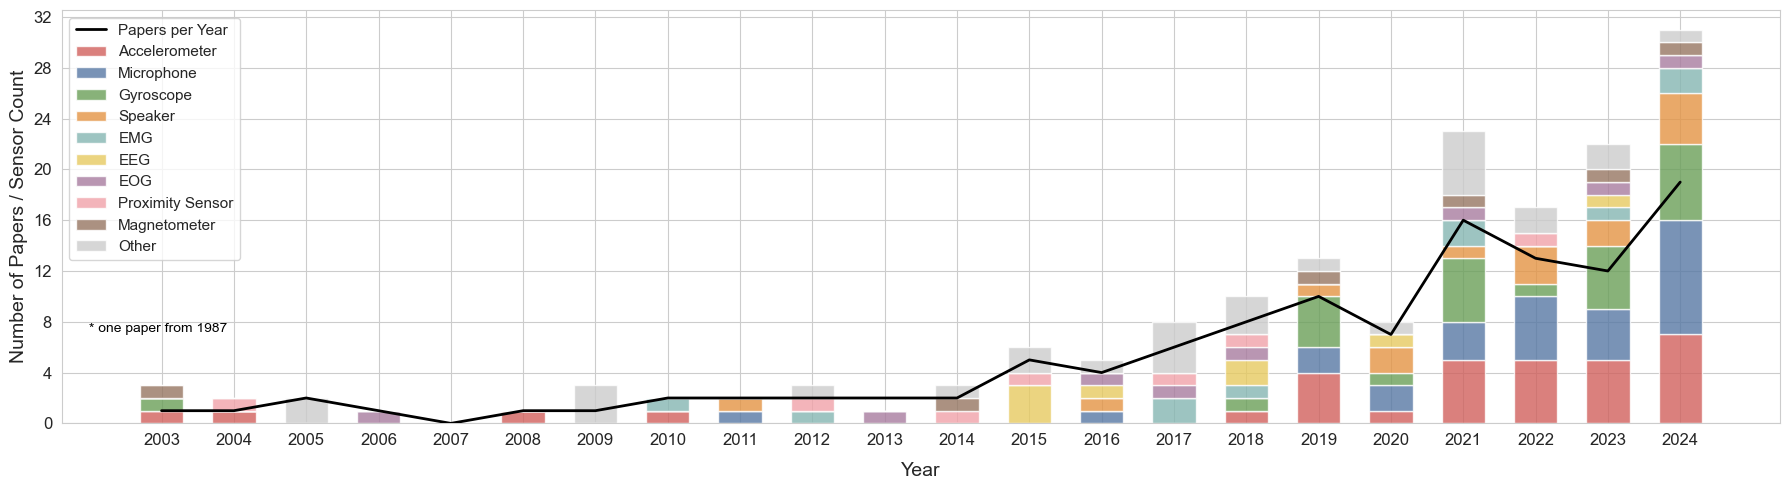

Summary Statistics (2003-2024):
Total papers: 117
Years with papers: 21
Peak year: 2024 with 19 papers

Total sensor occurrences by type (sorted by frequency):
Accelerometer: 32
Microphone: 27
Gyroscope: 24
Speaker: 15
EMG: 10
EEG: 8
EOG: 8
Proximity Sensor: 7
Magnetometer: 6
Other: 29


In [12]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Custom colors - add grey for "Other" category
custom_colors = ['#d1615d', '#5778a4', '#6a9f58', '#e49444', '#85b6b2', '#e7ca60', '#a87c9f', '#f1a2a9', '#967662', '#b8b0ac', '#cccccc']

# Get papers per year (excluding 1987)
papers_per_year_filtered = {year: count for year, count in papers_per_year.items() if year >= 2003}

# Convert sensor counts to regular dict and filter years
sensor_counts_regular = {year: dict(sensors) for year, sensors in sensor_counts_by_year.items() if year >= 2003}

# Create year range from 2003 to 2024
years = list(range(2003, 2025))

# Prepare data for plotting
papers_data = [papers_per_year_filtered.get(year, 0) for year in years]

# Prepare sensor data for stacked bars
target_sensors_with_other = target_sensors + ['Other']
sensor_data = {sensor: [] for sensor in target_sensors_with_other}

for year in years:
    year_sensors = sensor_counts_regular.get(year, {})
    for sensor in target_sensors_with_other:
        sensor_data[sensor].append(year_sensors.get(sensor, 0))

# Calculate total occurrences for each sensor and sort by count (descending)
sensor_totals = {sensor: sum(sensor_data[sensor]) for sensor in target_sensors_with_other}

# Sort sensors but keep "Other" at the end
sorted_sensors_temp = sorted(sensor_totals.items(), key=lambda x: x[1], reverse=True)
sorted_sensors = []
other_sensor = None

# Separate "Other" from the rest
for sensor, total in sorted_sensors_temp:
    if sensor == 'Other':
        other_sensor = (sensor, total)
    else:
        sorted_sensors.append((sensor, total))

# Add "Other" at the end if it exists
if other_sensor:
    sorted_sensors.append(other_sensor)

sorted_sensor_names = [sensor for sensor, total in sorted_sensors if total > 0]

# Set figure size and style to match your existing plot
plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")

# Create stacked bar chart with sorted sensors
bottom = np.zeros(len(years))

# Ensure we have enough colors for all sensors including "Other"
for i, sensor in enumerate(sorted_sensor_names):
    values = sensor_data[sensor]
    # Use the last color (grey) specifically for "Other"
    if sensor == 'Other':
        color = custom_colors[-1]  # Last color (grey)
    else:
        color = custom_colors[i % (len(custom_colors) - 1)]  # Exclude the last color for others
    
    plt.bar(years, values, bottom=bottom, label=sensor, color=color, alpha=0.8, width=0.6)
    bottom += values

# Add line plot for papers per year on the SAME axis
line = plt.plot(years, papers_data, color='black', linewidth=2, label='Papers per Year', zorder=10)

# Formatting to match your style
plt.xlabel('Year', labelpad=10)
plt.ylabel('Number of Papers / Sensor Count')

# Set x-axis ticks - show every other year to avoid crowding
plt.xticks(years)

# Set y-axis to show only integers (matching your style)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Legend matching your style
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=11)

# Add text annotation for 1987 paper
plt.text(2002, plt.ylim()[1] * 0.22, '* one paper from 1987', fontsize=10, 
         color='black', transform=plt.gca().transData)

plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/sensor_timeline_fig.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("Summary Statistics (2003-2024):")
print(f"Total papers: {sum(papers_data)}")
print(f"Years with papers: {sum(1 for p in papers_data if p > 0)}")
print(f"Peak year: {years[papers_data.index(max(papers_data))]} with {max(papers_data)} papers")
print(f"\nTotal sensor occurrences by type (sorted by frequency):")
for sensor, total in sorted_sensors:
    if total > 0:
        print(f"{sensor}: {total}")

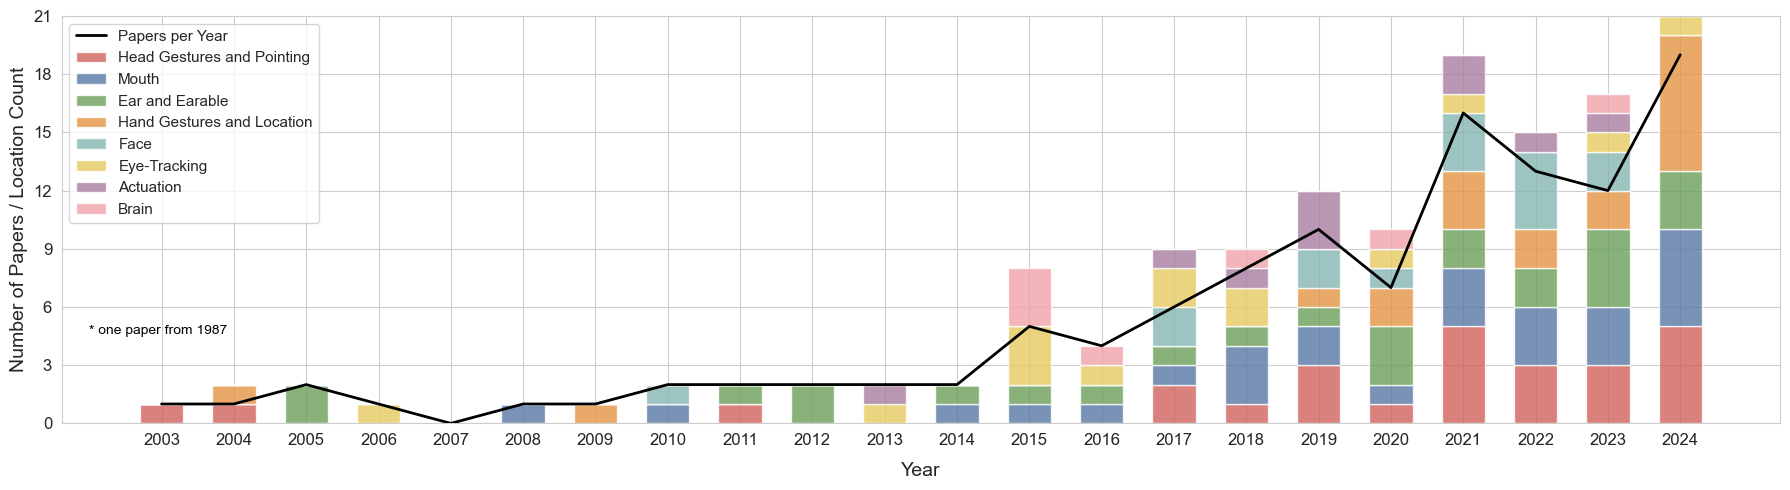

In [13]:
# get count of papers per year
year_counter = Counter(df['Year'].to_list())
papers_per_year = dict(year_counter.items())

# only take into account the sensors with at least 5 papers
target_locations = ['Actuation', 'Brain', 'Ear and Earable', 'Eye-Tracking', 'Face', 'Hand Gestures and Location', 'Head Gestures and Pointing', 'Mouth']

location_counts_by_year = defaultdict(lambda: defaultdict(int))

# Process each row
for index, row in df.iterrows():
    year = row['Year']
    locations_str = row['Location']
    
    # Skip if sensors field is NaN
    if pd.isna(locations_str):
        continue
    
    # Split by comma and clean up whitespace
    locations_in_row = [location.strip() for location in str(locations_str).split(',')]
    
    # Count each target sensor
    for location in locations_in_row:
        if location in target_locations:
            location_counts_by_year[year][location] += 1
        else:
            # Add to "Other" category
            location_counts_by_year[year]['Other'] += 1

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Custom colors - add grey for "Other" category
custom_colors = ['#d1615d', '#5778a4', '#6a9f58', '#e49444', '#85b6b2', '#e7ca60', '#a87c9f', '#f1a2a9', '#967662', '#b8b0ac', '#cccccc']

# Get papers per year (excluding 1987)
papers_per_year_filtered = {year: count for year, count in papers_per_year.items() if year >= 2003}

# Convert sensor counts to regular dict and filter years
location_counts_regular = {year: dict(locations) for year, locations in location_counts_by_year.items() if year >= 2003}

# Create year range from 2003 to 2024
years = list(range(2003, 2025))

# Prepare data for plotting
papers_data = [papers_per_year_filtered.get(year, 0) for year in years]

# Prepare sensor data for stacked bars
target_locations_with_other = target_locations + ['Other']
location_data = {location: [] for location in target_locations_with_other}

for year in years:
    year_locations = location_counts_regular.get(year, {})
    for location in target_locations_with_other:
        location_data[location].append(year_locations.get(location, 0))

# Calculate total occurrences for each sensor and sort by count (descending)
location_totals = {location: sum(location_data[location]) for location in target_locations_with_other}

# Sort sensors but keep "Other" at the end
sorted_locations_temp = sorted(location_totals.items(), key=lambda x: x[1], reverse=True)
sorted_locations = []
other_location = None

# Separate "Other" from the rest
for location, total in sorted_locations_temp:
    if location == 'Other':
        other_location = (location, total)
    else:
        sorted_locations.append((location, total))

# Add "Other" at the end if it exists
if other_location:
    sorted_locations.append(other_location)

sorted_location_names = [location for location, total in sorted_locations if total > 0]

# Set figure size and style to match your existing plot
plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")

# Create stacked bar chart with sorted sensors
bottom = np.zeros(len(years))

# Ensure we have enough colors for all sensors including "Other"
for i, location in enumerate(sorted_location_names):
    values = location_data[location]
    # Use the last color (grey) specifically for "Other"
    if location == 'Other':
        color = custom_colors[-1]  # Last color (grey)
    else:
        color = custom_colors[i % (len(custom_colors) - 1)]  # Exclude the last color for others
    
    plt.bar(years, values, bottom=bottom, label=location, color=color, alpha=0.8, width=0.6)
    bottom += values

# Add line plot for papers per year on the SAME axis
line = plt.plot(years, papers_data, color='black', linewidth=2, label='Papers per Year', zorder=10)

# Formatting to match your style
plt.xlabel('Year', labelpad=10)
plt.ylabel('Number of Papers / Location Count')

# Set x-axis ticks - show every other year to avoid crowding
plt.xticks(years)

# Set y-axis to show only integers (matching your style)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Legend matching your style
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=11)

# Add text annotation for 1987 paper
plt.text(2002, plt.ylim()[1] * 0.22, '* one paper from 1987', fontsize=10, 
         color='black', transform=plt.gca().transData)

plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/location_timeline_fig.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
keywords = df['Keywords'].dropna()
keywords

1               Gestural Interaction, Wearable Computing
4      Capacitive Touch Control, Headphones, MP3, Mus...
5      EOG, Gaze Interface, Headphone, Kalman Filter,...
6      Assistive Technology, Computer Interfaces, Spi...
7      Audio Feedback, Hand Gesture, Input Device, In...
                             ...                        
113    Adversarial Learning, Implicit Authentication,...
114    Acoustic Sensing, Earable, Face and Ear Intera...
115    Earphones, Head Motion, Ubiquitous Computing, ...
116    Acoustic Sensing, Gesture Detection, Wearable ...
117    EMG Signals, Silent Command Recognition, User ...
Name: Keywords, Length: 105, dtype: object

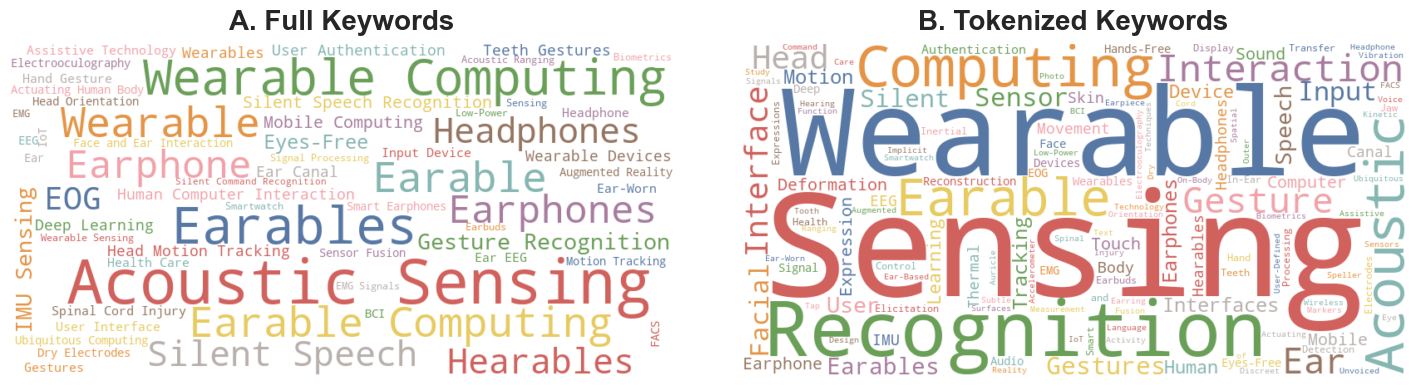

=== FULL KEYWORDS STATISTICS ===
Unique full keywords with ≥2 occurrences: 61
Most common full keywords:
  1. Acoustic Sensing: 16 (color: #d1615d)
  2. Earables: 11 (color: #5778a4)
  3. Wearable Computing: 10 (color: #6a9f58)
  4. Wearable: 7 (color: #e49444)
  5. Earable: 7 (color: #85b6b2)
  6. Earable Computing: 7 (color: #e7ca60)
  7. Earphones: 6 (color: #a87c9f)
  8. Earphone: 6 (color: #f1a2a9)
  9. Headphones: 5 (color: #967662)
  10. Silent Speech: 5 (color: #b8b0ac)

=== INDIVIDUAL WORDS STATISTICS ===
Unique individual words with ≥2 occurrences: 131
Most common individual words:
  1. Sensing: 39 (color: #d1615d)
  2. Wearable: 27 (color: #5778a4)
  3. Recognition: 24 (color: #6a9f58)
  4. Computing: 22 (color: #e49444)
  5. Acoustic: 21 (color: #85b6b2)
  6. Earable: 20 (color: #e7ca60)
  7. Interaction: 19 (color: #a87c9f)
  8. Gesture: 17 (color: #f1a2a9)
  9. Ear: 17 (color: #967662)
  10. Head: 14 (color: #b8b0ac)


In [15]:
def create_keyword_wordclouds(df, min_count=2):
    """
    Create side-by-side wordclouds for full keywords and individual words.
    
    Parameters:
    df: DataFrame containing the 'Keywords' column
    min_count: Minimum occurrence count to include words/keywords
    """
    
    # Define your custom colors
    custom_colors = ['#d1615d', '#5778a4', '#6a9f58', '#e49444', '#85b6b2', '#e7ca60', '#a87c9f', '#f1a2a9', '#967662', '#b8b0ac']
    
    # Extract full keywords
    all_full_keywords = []
    for keywords in df['Keywords'].dropna():
        keyword_list = [keyword.strip() for keyword in keywords.split(',')]
        all_full_keywords.extend(keyword_list)
    
    # Extract individual words
    all_individual_words = []
    for keywords in df['Keywords'].dropna():
        keyword_list = [keyword.strip() for keyword in keywords.split(',')]
        for keyword in keyword_list:
            words = keyword.split()
            all_individual_words.extend(words)
    
    # Count occurrences
    full_keyword_counts = Counter(all_full_keywords)
    individual_word_counts = Counter(all_individual_words)
    
    # Apply min_count filter to create frequency dictionaries for WordCloud
    full_keyword_freq = {word: count for word, count in full_keyword_counts.items() if count >= min_count}
    individual_word_freq = {word: count for word, count in individual_word_counts.items() if count >= min_count}
    
    # Get sorted lists for color mapping (most frequent first, filtered by min_count)
    sorted_full_keywords = [word for word, count in full_keyword_counts.most_common() if count >= min_count]
    sorted_individual_words = [word for word, count in individual_word_counts.most_common() if count >= min_count]
    
    # Create color mappings based on rank
    full_keyword_colors = {word: custom_colors[i % len(custom_colors)] for i, word in enumerate(sorted_full_keywords)}
    individual_word_colors = {word: custom_colors[i % len(custom_colors)] for i, word in enumerate(sorted_individual_words)}
    
    # Color functions
    def color_func_full(word, **kwargs):
        return full_keyword_colors.get(word, custom_colors[0])
    
    def color_func_individual(word, **kwargs):
        return individual_word_colors.get(word, custom_colors[0])
    
    # Create figure with subplots
    plt.figure(figsize=(18, 5))
    
    # Full keywords wordcloud - now uses filtered frequencies
    plt.subplot(1, 2, 1)
    if full_keyword_freq:
        wordcloud1 = WordCloud(
            width=800, height=400, background_color='white',
            color_func=color_func_full,
            relative_scaling=0.5, random_state=42
        ).generate_from_frequencies(full_keyword_freq)
        plt.imshow(wordcloud1, interpolation='bilinear')
    plt.axis('off')
    plt.title('A. Full Keywords', fontsize=20, fontweight='bold', pad=10)

    # Individual words wordcloud - now uses filtered frequencies
    plt.subplot(1, 2, 2)
    if individual_word_freq:
        wordcloud2 = WordCloud(
            width=800, height=400, background_color='white',
            color_func=color_func_individual,
            relative_scaling=0.5, random_state=42
        ).generate_from_frequencies(individual_word_freq)
        plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis('off')
    plt.title('B. Tokenized Keywords', fontsize=20, fontweight='bold', pad=10)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/keywords_wordcloud_comparison.png", 
                format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("=== FULL KEYWORDS STATISTICS ===")
    print(f"Unique full keywords with ≥{min_count} occurrences: {len(sorted_full_keywords)}")
    print("Most common full keywords:")
    for i, word in enumerate(sorted_full_keywords[:10]):
        count = full_keyword_counts[word]
        color = full_keyword_colors[word]
        print(f"  {i+1}. {word}: {count} (color: {color})")
    
    print(f"\n=== INDIVIDUAL WORDS STATISTICS ===")
    print(f"Unique individual words with ≥{min_count} occurrences: {len(sorted_individual_words)}")
    print("Most common individual words:")
    for i, word in enumerate(sorted_individual_words[:10]):
        count = individual_word_counts[word]
        color = individual_word_colors[word]
        print(f"  {i+1}. {word}: {count} (color: {color})")

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Call the function
create_keyword_wordclouds(df, min_count=2)

In [16]:
normalized_abstract_similarity_df = pd.read_csv('abstract_similarity_datasets/normalized_abstract_similarity.csv', index_col=0)
normalized_database_similarity_df = pd.read_csv('database_similarity_datasets/normalized_database_similarity.csv', index_col=0)
normalized_database_similarity_df

,1,2,3,4,5,6,7,8,9,10,...,109,110,111,112,113,114,115,116,117,118
1,NaN,-0.673811,0.007899,0.523555,-0.563640,0.103469,0.512890,0.489528,0.297126,0.189244,...,-0.771028,0.168656,-0.538541,-0.220953,-0.641039,-0.005190,-1.083041,-0.647634,0.130364,-0.265618
2,-0.673811,NaN,0.117970,-0.771028,-1.400519,0.103469,0.347194,-0.889045,0.562958,1.483827,...,0.404775,-0.170552,-1.617359,-0.652481,-1.935621,0.571813,-1.655664,0.959696,-0.961685,-0.265618
3,0.007899,0.117970,NaN,0.333968,-0.808953,1.314624,0.694455,0.873037,0.694455,-0.220953,...,-0.965462,0.512919,-0.991398,0.241597,-0.122397,0.565243,-0.620490,-1.381477,0.181053,-0.071184
4,0.523555,-0.771028,0.333968,NaN,1.021607,0.256777,0.523555,0.913120,0.523555,-0.771028,...,-0.410541,0.913164,0.205968,1.170846,0.563903,1.170846,0.308758,-0.313324,1.583885,0.478890
5,-0.563640,-1.400519,-0.808953,1.021607,NaN,-1.154063,-0.827896,0.286833,-0.827896,-2.122478,...,-0.980642,0.041964,-0.120200,0.848540,0.660036,0.007800,0.499685,-0.563640,1.237419,-0.758824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-0.005190,0.571813,0.565243,1.170846,0.007800,-0.624519,0.452514,0.741708,0.452514,-0.220953,...,-0.965462,1.225861,-0.128343,1.483827,1.872275,NaN,0.670231,2.178624,0.959001,0.193071
115,-1.083041,-1.655664,-0.620490,0.308758,0.499685,-1.444612,-0.818785,0.833163,-1.083041,-1.730332,...,-1.693491,0.003706,0.515251,2.100802,2.681091,0.670231,NaN,-0.589933,1.095201,-0.843942
116,-0.647634,0.959696,-1.381477,-0.313324,-0.563640,-1.380700,-0.189930,-0.805055,-0.189930,0.431184,...,-1.607906,0.194548,0.371284,0.463128,1.415509,2.178624,-0.589933,NaN,0.304417,-0.838241
117,0.130364,-0.961685,0.181053,1.583885,1.237419,-0.005993,0.130364,1.078062,0.297494,-0.414250,...,-0.805435,1.139407,2.176307,2.807148,1.984844,0.959001,1.095201,0.304417,NaN,0.178172


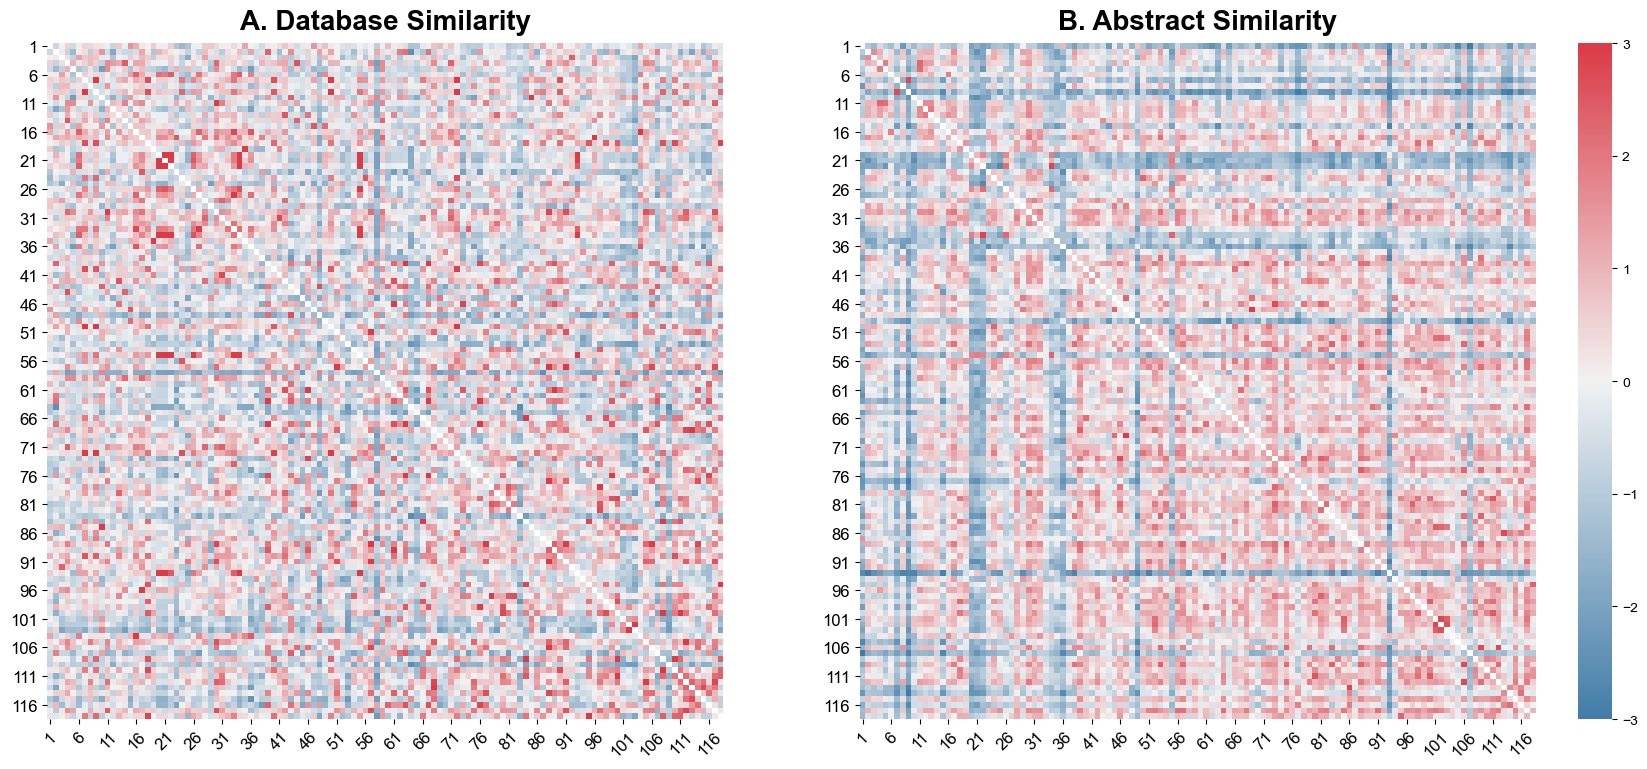

In [17]:
sns.reset_defaults()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Arial'] + plt.rcParams['font.serif']

matrix_cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7.8))

# Set consistent color scale limits
vmin, vmax = -3, 3

# First subplot - Database Similarity
hm1 = sns.heatmap(normalized_database_similarity_df, cmap=matrix_cmap, 
            vmin=vmin, vmax=vmax, cbar=False,
            square=True, xticklabels=False, yticklabels=False, ax=axes[0])
axes[0].set_title('A. Database Similarity', fontsize=20, fontweight='bold', pad=10)

# Get indices at every 5th position
x_indices = np.arange(0, len(normalized_database_similarity_df.columns), 5)
y_indices = np.arange(0, len(normalized_database_similarity_df.index), 5)

# Set tick positions (add 0.5 to center the ticks in the heatmap cells)
axes[0].set_xticks(x_indices + 0.5)
axes[0].set_yticks(y_indices + 0.5)

# Set tick labels
axes[0].set_xticklabels(normalized_database_similarity_df.columns[x_indices], rotation=45, fontsize=12)
axes[0].set_yticklabels(normalized_database_similarity_df.index[y_indices], fontsize=12)

# Second subplot - Abstract Similarity (with colorbar)
hm2 = sns.heatmap(normalized_abstract_similarity_df, cmap=matrix_cmap, 
                 vmin=vmin, vmax=vmax, cbar=True,
                 square=True, xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_title('B. Abstract Similarity', fontsize=20, fontweight='bold', pad=10)

# Get indices for second plot
x_indices2 = np.arange(0, len(normalized_abstract_similarity_df.columns), 5) 
y_indices2 = np.arange(0, len(normalized_abstract_similarity_df.index), 5)

# Set tick positions
axes[1].set_xticks(x_indices2 + 0.5)
axes[1].set_yticks(y_indices2 + 0.5)

# Set tick labels
axes[1].set_xticklabels(normalized_abstract_similarity_df.columns[x_indices2], rotation=45, fontsize=12)
axes[1].set_yticklabels(normalized_abstract_similarity_df.index[y_indices2], fontsize=12)

# Adjust colorbar
cbar = hm2.collections[0].colorbar

plt.tight_layout()
plt.savefig("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/figs/similarity_matrices_comparison.png", 
            format='png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
venues = pd.read_csv("Dimensions_250702.csv", skiprows=2, keep_default_na=False)['Venue']

venues.value_counts()



Venue
                                                                                                         46
Proceedings of the ACM on Interactive, Mobile, Wearable and Ubiquitous Technologies (IMWUT) / Ubicomp    14
ACM Conference on Human Factors in Computing Systems (CHI)                                               13
ACM International Symposium on Wearable Computers (ISWC)                                                 12
ACM Symposium on User Interface Software and Technology (UIST)                                            7
IEEE Internet of Things Journal                                                                           5
ACM Conference on Embedded Networked Sensor Systems (SenSys)                                              4
ACM International Conference on Mobile Computing and Networking (MobiCom)                                 4
ACM International Conference on Mobile Human-Computer Interaction (MobileHCI)                             3
ACM International Conf

In [19]:
# Publishers of backward-chained papers
publishers = {
    610: 'ACM',
    611: 'ACM',
    614: 'IEE', 
    616: 'ACM',
    617: 'ACM',
    618: 'ACM', 
    619: 'ACM',
    620: 'ACM',
    621: 'ACM',
    622: 'Springer', 
    623: 'IEEE', 
    624: 'Sage', 
    626: 'ACM',
    627: 'MDPI', 
    628: 'ACM', 
    629: 'ACM',
    712: 'ACM', 
    713: 'ACM', 
    714: 'ACM',
    
}